# Kaggle Tabular Project

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow, fastparquet
import math

### Define Project and Data Overview

[Harmful Brain Activity Multiclass Classification](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/overview)

This is a supervised multiclass classification problem with the goal of using EEG and Spectrogram data to classify different types of brain activity. There isn't feature data. That has to be derived from the EEG and Spectrogram data provided. The target variable has 6 classes: Other, LPD, GPD, LRDA, GRDA, and Seizure. The problem is to extract features from the EEG and Spectrogram data and then build a classification model which will predict the type of activity the test EEG and test Spectrogram represent. These classifications are supposed to be given probabilistically. In other words, I'll identify the probability the test EEG and Spectrogram show seizure activity, the probability they show LRDA activity, the probability they show GRDA activity, etc.

##### Describe the Data

As mentioned, I'm given both EEG and Spectrogram data. These are accessible using the metadata in train.csv.

In [68]:
training = pd.read_csv('train.csv')

In [65]:
training

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0       1628180742           0                       0.0          353733   
1       1628180742           1                       6.0          353733   
2       1628180742           2                       8.0          353733   
3       1628180742           3                      18.0          353733   
4       1628180742           4                      24.0          353733   
...            ...         ...                       ...             ...   
106795   351917269           6                      12.0      2147388374   
106796   351917269           7                      14.0      2147388374   
106797   351917269           8                      16.0      2147388374   
106798   351917269           9                      18.0      2147388374   
106799   351917269          10                      20.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                        0                               0.0   127492639   
1                        1                               6.0  3887563113   
2                        2                               8.0  1142670488   
3                        3                              18.0  2718991173   
4                        4                              24.0  3080632009   
...                    ...                               ...         ...   
106795                   6                              12.0  4195677307   
106796                   7                              14.0   290896675   
106797                   8                              16.0   461435451   
106798                   9                              18.0  3786213131   
106799                  10                              20.0  3642716176   

        patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
0            42516          Seizure             3         0         0   
1            42516          Seizure             3         0         0   
2            42516          Seizure             3         0         0   
3            42516          Seizure             3         0         0   
4            42516          Seizure             3         0         0   
...            ...              ...           ...       ...       ...   
106795       10351             LRDA             0         0         0   
106796       10351             LRDA             0         0         0   
106797       10351             LRDA             0         0         0   
106798       10351             LRDA             0         0         0   
106799       10351             LRDA             0         0         0   

        lrda_vote  grda_vote  other_vote  
0               0          0           0  
1               0          0           0  
2               0          0           0  
3               0          0           0  
4               0          0           0  
...           ...        ...         ...  
106795          3          0           0  
106796          3          0           0  
106797          3          0           0  
106798          3          0           0  
106799          3          0           0  

[106800 rows x 15 columns]

The csv contains information about the EEG and Spectrogram data which are contained in parquets. For the EEG data, you get the overall EEG ID which corresponds to a single parquet. The parquet is named 'idnumber.parquet' and in many cases contains many sub EEGs.  
  
The sub EEGs are listed in order and attainable using the eeg_label_offset_seconds data. There are 200 rows of data per second of EEG recording. So an offset of 6 seconds means that sub EEG will start at row 1200 in the overall EEG data. A sub EEG is 50 seconds long, so it contains 10000 rows of data. So, to acquire a sub EEG starting 6 seconds into the overall recording, you'd take rows 1200 through 11200.  
  
The test EEG is a 50 second EEG recording, so it has the same dimensions of the sub EEGs.  
  
Every EEG has 20 columns of data. Each column is the location of an electrode used to get electrical readings from the brain. The column labels tell you which region and which location in that region. So, Fp1 is the first prefrontal cortex location.

In [4]:
example_eeg = pd.read_parquet('train_eegs/' + str(training['eeg_id'][0]) + '.parquet', engine = 'pyarrow')

In [5]:
example_eeg

Fp1          F3          C3          P3          F7          T3  \
0      -80.519997  -70.540001  -80.110001 -108.750000 -120.330002  -88.620003   
1      -80.449997  -70.330002  -81.760002 -107.669998 -120.769997  -90.820000   
2      -80.209999  -75.870003  -82.050003 -106.010002 -117.500000  -87.489998   
3      -84.709999  -75.339996  -87.480003 -108.970001 -121.410004  -94.750000   
4      -90.570000  -80.790001  -93.000000 -113.870003 -129.960007 -102.860001   
...           ...         ...         ...         ...         ...         ...   
17995 -144.660004 -147.809998 -129.820007 -129.460007 -157.509995 -124.000000   
17996 -140.880005 -153.000000 -129.529999 -129.020004 -154.059998 -131.220001   
17997 -133.729996 -141.770004 -121.900002 -122.370003 -158.750000 -123.550003   
17998 -141.449997 -151.139999 -127.190002 -128.699997 -163.460007 -124.309998   
17999 -138.669998 -147.210007 -122.820000 -128.289993 -164.869995 -124.239998   

               T5          O1          Fz          Cz         Pz         Fp2  \
0     -101.750000 -104.489998  -99.129997  -90.389999 -97.040001  -77.989998   
1     -104.260002  -99.730003  -99.070000  -92.290001 -96.019997  -84.500000   
2      -99.589996  -96.820000 -119.680000  -99.360001 -91.110001  -99.440002   
3     -105.370003 -100.279999 -113.839996 -102.059998 -95.040001  -99.230003   
4     -118.599998 -101.099998 -107.660004 -102.339996 -98.510002  -95.300003   
...           ...         ...         ...         ...        ...         ...   
17995 -124.570000  -94.820000 -153.070007 -121.110001 -86.459999 -132.520004   
17996 -128.380005  -95.000000 -140.820007 -114.639999 -84.379997 -115.339996   
17997 -127.730003  -93.089996 -125.230003 -106.489998 -83.419998 -112.720001   
17998 -129.479996  -94.419998 -140.869995 -113.339996 -83.519997 -129.300003   
17999 -129.339996  -95.320000 -136.789993 -112.820000 -84.660004 -129.380005   

               F4          C4          P4          F8         T4          T6  \
0      -88.830002 -112.120003 -108.110001  -95.949997 -98.360001 -121.730003   
1      -84.989998 -115.610001 -103.860001  -97.470001 -89.290001 -115.500000   
2     -104.589996 -127.529999 -113.349998  -95.870003 -96.019997 -123.879997   
3     -101.220001 -125.769997 -111.889999  -97.459999 -97.180000 -128.940002   
4      -88.930000 -115.639999  -99.800003  -97.500000 -88.730003 -114.849998   
...           ...         ...         ...         ...        ...         ...   
17995 -138.339996 -128.970001  -71.300003 -114.480003 -86.709999 -114.959999   
17996 -119.230003 -114.709999  -70.989998  -92.129997 -79.639999 -116.139999   
17997 -103.209999 -107.629997  -61.869999  -97.910004 -77.150002 -106.500000   
17998 -118.650002 -117.589996  -71.879997  -99.279999 -83.900002 -116.160004   
17999 -123.180000 -122.889999  -79.910004 -101.459999 -84.339996 -125.989998   

               O2        EKG  
0     -106.449997   7.920000  
1     -102.059998  29.219999  
2     -105.790001  45.740002  
3     -109.889999  83.870003  
4     -100.250000  97.769997  
...           ...        ...  
17995  -81.500000 -20.070000  
17996  -81.879997  10.600000  
17997  -75.339996  -2.060000  
17998  -81.410004   2.820000  
17999  -89.110001  35.279999  

[18000 rows x 20 columns]

In [6]:
training[training['eeg_id'] == 1628180742]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   
5  1628180742           5                      26.0          353733   
6  1628180742           6                      30.0          353733   
7  1628180742           7                      36.0          353733   
8  1628180742           8                      40.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   
5                   5                              26.0  2413091605   
6                   6                              30.0   364593930   
7                   7                              36.0  3811483573   
8                   8                              40.0  3388718494   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   
5       42516          Seizure             3         0         0          0   
6       42516          Seizure             3         0         0          0   
7       42516          Seizure             3         0         0          0   
8       42516          Seizure             3         0         0          0   

   grda_vote  other_vote  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0  
5          0           0  
6          0           0  
7          0           0  
8          0           0

Above is the first EEG in the dataset. It has 9 sub EEGs. Below is one of those sub EEGs.

In [7]:
example_sub_eeg = example_eeg.iloc[1200:11200]

In [8]:
example_sub_eeg

Fp1          F3          C3          P3          F7          T3  \
1200  -129.460007 -115.580002 -115.129997 -157.440002 -166.979996 -126.260002   
1201  -128.740005 -112.330002 -112.059998 -154.830002 -164.440002 -121.230003   
1202  -128.600006 -112.550003 -107.489998 -148.360001 -154.089996 -114.110001   
1203  -123.449997 -106.440002 -108.870003 -148.309998 -158.080002 -118.129997   
1204  -129.770004 -119.430000 -111.879997 -148.029999 -145.830002 -118.040001   
...           ...         ...         ...         ...         ...         ...   
11195 -156.139999 -149.660004 -115.019997 -130.360001 -167.929993  -94.500000   
11196 -168.899994 -157.619995 -168.679993 -141.410004 -199.839996 -118.550003   
11197 -164.080002 -143.070007 -211.740005 -165.570007 -201.369995  -90.730003   
11198 -168.080002 -148.940002 -118.269997 -145.429993 -162.889999 -128.440002   
11199 -166.410004 -125.389999  -84.360001 -107.910004 -212.220001 -111.010002   

               T5          O1          Fz          Cz          Pz         Fp2  \
1200  -133.429993 -124.349998 -116.629997 -112.110001 -117.040001 -103.169998   
1201  -135.380005 -122.269997 -114.930000 -107.370003 -111.059998 -100.480003   
1202  -129.470001 -115.989998 -123.620003 -104.839996 -100.190002 -104.250000   
1203  -133.350006 -117.790001 -106.150002  -95.480003  -97.440002  -93.980003   
1204  -140.699997 -113.980003  -97.209999  -85.459999  -91.620003  -83.529999   
...           ...         ...         ...         ...         ...         ...   
11195 -117.029999 -130.899994 -137.979996 -129.869995 -122.279999 -127.019997   
11196 -114.269997 -132.399994 -169.940002 -158.889999 -131.960007 -159.110001   
11197 -120.489998 -134.940002 -170.300003 -168.910004 -143.000000 -159.619995   
11198 -120.709999 -123.620003 -124.800003 -108.779999 -117.269997 -135.500000   
11199 -116.050003 -122.620003 -123.230003 -112.529999 -115.040001 -140.350006   

               F4          C4          P4          F8          T4          T6  \
1200  -100.070000 -133.970001 -103.449997 -100.059998  -90.040001 -132.460007   
1201   -96.330002 -122.019997  -95.400002  -98.309998  -83.660004 -122.070000   
1202  -106.040001 -116.940002  -96.059998  -96.620003  -91.120003 -127.430000   
1203   -90.500000 -109.900002  -86.510002  -93.559998  -86.019997 -121.650002   
1204   -71.750000  -96.820000  -71.599998  -85.779999  -68.370003 -105.889999   
...           ...         ...         ...         ...         ...         ...   
11195 -133.919998 -183.699997  -83.559998 -112.889999 -124.989998 -150.190002   
11196 -186.610001 -278.440002 -106.930000 -113.339996   -1.440000 -167.160004   
11197 -211.259995 -271.290009 -116.010002  -68.989998 -131.259995 -179.529999   
11198 -126.430000  -23.309999  -87.169998  -90.980003 -148.750000 -162.380005   
11199 -107.489998 -113.349998 -102.250000 -123.139999  -92.150002 -172.839996   

               O2         EKG  
1200  -107.230003   -5.900000  
1201   -97.180000    9.670000  
1202   -93.900002   -3.030000  
1203   -92.110001   33.880001  
1204   -85.059998   65.309998  
...           ...         ...  
11195 -126.360001  100.959999  
11196 -134.429993  120.190002  
11197 -141.350006  148.399994  
11198 -129.490005  123.660004  
11199 -133.559998  102.169998  

[10000 rows x 20 columns]

The offsets for the sub EEGs aren't consistent. They vary from EEG to EEG. Sub EEGs will overlap with one another. When comparing sub EEGs it will be important to re-index them. As seen above, the sub EEG starts with row 1200. When attempting to index over it, starting with 0 as the 1st index would result in an error.  
  
Each sub EEG has been classified by experts. This information is found in the 'expert_consensus' column of the training csv. The possible options are the 6 I listed above: Other, LPD, GPD, LRDA, GRDA, and Seizure. The number of votes in the consensus varies row to row. Sometimes there is as few as 1 vote and sometimes there are closer to 30 votes.

In [9]:
example_spectrogram = pd.read_parquet('train_spectrograms/' + str(training['spectrogram_id'][0])
                                      + '.parquet', engine = 'pyarrow')

In [10]:
example_spectrogram

time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37    LL_1.56    LL_1.76  \
0       1     4.26    10.98     9.05    13.65    11.49   8.930000  18.840000   
1       3     2.65     3.97    12.18    13.26    14.21  13.230000   9.650000   
2       5     4.18     4.53     8.77    14.26    13.36  16.559999  19.219999   
3       7     2.41     3.21     4.92     8.07     5.97  12.420000  10.820000   
4       9     2.29     2.44     2.77     4.62     5.39   7.080000   9.840000   
..    ...      ...      ...      ...      ...      ...        ...        ...   
315   631     6.36     6.59     6.60     7.30     4.48   8.400000  13.420000   
316   633     4.90     8.80     8.22     5.83    10.21  10.580000  10.250000   
317   635     6.07     7.85    11.26     9.20     8.18   9.130000  10.450000   
318   637     3.41     3.75     4.80     6.45     6.70   7.960000   8.160000   
319   639     2.88     3.71     4.02     6.07     5.63   5.460000   6.270000   

     LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  \
0      19.26  19.240000  ...      0.31      0.17      0.28      0.19   
1       8.11  11.280000  ...      0.15      0.13      0.14      0.24   
2      17.51  22.650000  ...      0.29      0.21      0.16      0.25   
3      14.96  21.809999  ...      0.33      0.51      0.49      0.64   
4      12.27  14.410000  ...      0.44      0.38      0.48      0.63   
..       ...        ...  ...       ...       ...       ...       ...   
315    13.85  16.010000  ...      0.14      0.05      0.06      0.04   
316    13.68  19.549999  ...      0.16      0.08      0.06      0.06   
317    15.09  23.020000  ...      0.15      0.13      0.13      0.13   
318     6.97   9.700000  ...      0.13      0.11      0.13      0.07   
319     4.99   6.220000  ...      0.16      0.13      0.14      0.16   

     RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0        0.24      0.27      0.29      0.16      0.22      0.19  
1        0.24      0.36      0.35      0.31      0.36      0.40  
2        0.28      0.28      0.34      0.48      0.44      0.48  
3        0.58      0.42      0.32      0.31      0.32      0.33  
4        0.45      0.45      0.49      0.33      0.31      0.34  
..        ...       ...       ...       ...       ...       ...  
315      0.04      0.04      0.05      0.05      0.08      0.11  
316      0.07      0.04      0.06      0.09      0.07      0.08  
317      0.10      0.08      0.07      0.09      0.17      0.12  
318      0.11      0.12      0.09      0.16      0.19      0.19  
319      0.12      0.12      0.11      0.09      0.07      0.05  

[320 rows x 401 columns]

The spectrogram situation is similar to the EEG situation. Each overall spectrogram has its own ID which is used to access the parquet. That overall spectrogram will include sub spectrograms. These contain 10 minutes of data. There is not an equal number of EEGs and spectrograms, but each sub EEG will have a sub spectrogram associated with it.  
  
The test spectrogram has the same dimensions as the sub spectrograms. 300 rows x 401 columns. 1 column is time and the other 400 correspond to Hz values and regions of the brain. There are four regions: Left Lateral (LL), Left Parasagittal (LP), Right Lateral (RL), and Right Parasagittal (RP).  
  
The lateral plane divides top and bottom sections and the sagittal plane divides left and right sections.

In [11]:
example_sub_spectrogram = example_spectrogram.iloc[0:300]

In [12]:
example_sub_spectrogram

time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37    LL_1.56    LL_1.76  \
0       1     4.26    10.98     9.05    13.65    11.49   8.930000  18.840000   
1       3     2.65     3.97    12.18    13.26    14.21  13.230000   9.650000   
2       5     4.18     4.53     8.77    14.26    13.36  16.559999  19.219999   
3       7     2.41     3.21     4.92     8.07     5.97  12.420000  10.820000   
4       9     2.29     2.44     2.77     4.62     5.39   7.080000   9.840000   
..    ...      ...      ...      ...      ...      ...        ...        ...   
295   591     5.26     7.41    10.16     7.25    15.35  27.590000  28.650000   
296   593     5.17     7.17    10.05    13.47    13.22  11.560000  29.790001   
297   595     1.87     3.59     8.69     7.59     8.33  11.880000  12.690000   
298   597     3.27     5.63     9.46    11.19    11.98  12.260000   9.240000   
299   599     4.18     5.85     7.22    16.25    15.41  13.340000  16.809999   

       LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  \
0    19.260000  19.240000  ...      0.31      0.17      0.28      0.19   
1     8.110000  11.280000  ...      0.15      0.13      0.14      0.24   
2    17.510000  22.650000  ...      0.29      0.21      0.16      0.25   
3    14.960000  21.809999  ...      0.33      0.51      0.49      0.64   
4    12.270000  14.410000  ...      0.44      0.38      0.48      0.63   
..         ...        ...  ...       ...       ...       ...       ...   
295  27.600000  30.690001  ...      0.09      0.17      0.11      0.09   
296  24.660000  23.379999  ...      0.06      0.06      0.05      0.11   
297  16.360001  24.240000  ...      0.09      0.07      0.07      0.06   
298   7.030000   8.660000  ...      0.12      0.08      0.06      0.04   
299  12.640000  14.350000  ...      0.11      0.15      0.07      0.08   

     RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0        0.24      0.27      0.29      0.16      0.22      0.19  
1        0.24      0.36      0.35      0.31      0.36      0.40  
2        0.28      0.28      0.34      0.48      0.44      0.48  
3        0.58      0.42      0.32      0.31      0.32      0.33  
4        0.45      0.45      0.49      0.33      0.31      0.34  
..        ...       ...       ...       ...       ...       ...  
295      0.10      0.08      0.07      0.17      0.17      0.24  
296      0.09      0.08      0.16      0.21      0.20      0.20  
297      0.06      0.07      0.08      0.10      0.10      0.10  
298      0.04      0.06      0.05      0.08      0.13      0.14  
299      0.12      0.17      0.23      0.25      0.17      0.15  

[300 rows x 401 columns]

In [13]:
testing = pd.read_csv('test.csv')

In [14]:
testing

spectrogram_id      eeg_id  patient_id
0          853520  3911565283        6885

The testing set is just one EEG and one spectrogram with the same dimensions as the sub EEGs and sub spectrograms.

In [15]:
test_eeg = pd.read_parquet('test_eegs/3911565283.parquet', engine = 'pyarrow')
test_spectrogram = pd.read_parquet('test_spectrograms/853520.parquet', engine = 'pyarrow')

In [16]:
test_eeg

Fp1         F3         C3         P3         F7     T3         T5  \
0      9.210000 -47.459999  15.100000   8.220000 -16.900000 -22.99 -25.820000   
1     -3.590000 -30.290001  32.380001  10.800000 -68.980003 -21.60 -15.080000   
2    -26.040001 -60.070000   2.370000 -10.150000 -34.689999 -31.40 -31.920000   
3     -3.040000 -36.250000  29.559999  14.530000 -14.010000 -11.90 -14.230000   
4     -4.630000 -20.160000  25.190001   1.190000 -44.580002 -23.51 -30.709999   
...         ...        ...        ...        ...        ...    ...        ...   
9995 -26.889999 -45.480000 -17.250000 -23.570000  19.059999  -9.40 -27.120001   
9996 -24.049999 -41.689999 -13.450000 -26.219999  14.210000   0.02 -30.030001   
9997 -34.500000 -55.340000 -25.959999 -30.670000   8.890000  -9.74 -38.520000   
9998 -16.110001 -35.980000  -8.570000 -12.020000  28.580000   5.45 -20.510000   
9999  -3.260000 -17.840000   4.030000  -8.930000  34.270000   6.77 -15.670000   

             O1         Fz         Cz         Pz         Fp2         F4  \
0    -10.090000  28.370001  -3.010000 -27.299999  101.040001  35.110001   
1     -9.210000  26.360001  -8.980000 -32.279999   95.800003  26.389999   
2    -26.980000  -1.940000 -28.770000 -49.770000   73.449997  -3.680000   
3     -6.310000  26.040001  -2.770000 -25.030001   91.010002  22.610001   
4    -17.600000  25.420000  -8.860000 -33.959999   89.449997  19.440001   
...         ...        ...        ...        ...         ...        ...   
9995 -21.580000 -75.760002 -65.800003 -88.790001  -30.090000 -49.830002   
9996 -22.219999 -75.440002 -68.639999 -91.099998  -33.180000 -45.610001   
9997 -30.330000 -87.080002 -70.690002 -92.320000  -37.349998 -57.290001   
9998 -10.300000 -65.459999 -50.730000 -71.650002  -15.970000 -36.380001   
9999  -4.760000 -52.930000 -49.180000 -72.570000  -10.600000 -27.830000   

             C4         P4         F8         T4         T6     O2         EKG  
0     14.540000  18.330000  28.540001  44.090000  69.650002  30.74  171.679993  
1      4.820000  10.540000  20.559999  32.060001  59.439999  23.32  178.279999  
2    -17.320000 -16.150000  -8.270000   5.330000  45.180000   9.49  306.739990  
3      6.900000   9.930000  15.480000  33.580002  69.620003  31.01  223.259995  
4     -2.080000   6.110000   8.380000  24.180000  55.869999  19.91  170.759995  
...         ...        ...        ...        ...        ...    ...         ...  
9995 -75.339996 -61.139999 -71.889999 -53.299999  -8.130000 -12.38  -34.799999  
9996 -78.809998 -61.259998 -71.889999 -55.009998 -12.320000 -15.15  -27.799999  
9997 -80.209999 -67.320000 -72.919998 -57.110001 -12.330000 -15.20   21.980000  
9998 -59.660000 -46.310001 -51.520000 -39.740002   6.770000   3.74   -5.800000  
9999 -60.209999 -41.820000 -53.939999 -42.650002  -0.270000  -1.19  -54.950001  

[10000 rows x 20 columns]

10000 x 20 for the test EEG.

In [17]:
test_spectrogram

time    LL_0.59    LL_0.78    LL_0.98  LL_1.17  LL_1.37  LL_1.56  \
0       1  14.910000  17.110001  11.660000    11.73     6.08     4.54   
1       3  11.130000  10.950000  10.770000     5.07     4.03     3.24   
2       5  10.880000  10.570000   8.790000     5.33     2.44     1.48   
3       7  19.450001  18.200001  17.719999    13.38     4.17     1.88   
4       9  21.650000  22.530001  23.160000    17.00     7.19     3.89   
..    ...        ...        ...        ...      ...      ...      ...   
295   591  15.580000  18.209999  14.020000    15.96     4.36     4.98   
296   593  17.209999  20.219999  20.889999    17.16     9.15     4.14   
297   595   9.610000  13.320000   9.190000    11.50     8.11     5.53   
298   597   8.430000  11.840000  13.640000    10.56     8.63     5.80   
299   599  12.330000  11.840000   9.420000     6.31     3.65     2.50   

     LL_1.76  LL_1.95  LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  \
0       4.31     3.38     2.05  ...      0.07      0.06      0.05      0.06   
1       3.61     2.98     1.54  ...      0.05      0.04      0.04      0.04   
2       1.83     0.99     0.89  ...      0.04      0.04      0.04      0.03   
3       1.84     1.22     1.27  ...      0.03      0.03      0.05      0.08   
4       3.65     2.72     2.35  ...      0.04      0.04      0.05      0.05   
..       ...      ...      ...  ...       ...       ...       ...       ...   
295     2.68     2.22     2.03  ...      0.48      0.59      0.59      0.73   
296     2.49     2.71     1.60  ...      0.26      0.37      0.41      0.36   
297     5.57     3.69     3.19  ...      0.58      0.37      0.17      0.14   
298     2.98     1.48     0.96  ...      0.54      0.22      0.17      0.16   
299     2.38     1.69     1.07  ...      0.51      0.30      0.19      0.24   

     RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0        0.05      0.05      0.06      0.05      0.04      0.05  
1        0.04      0.04      0.03      0.03      0.03      0.02  
2        0.03      0.04      0.04      0.05      0.06      0.06  
3        0.07      0.07      0.08      0.03      0.03      0.03  
4        0.06      0.05      0.05      0.05      0.04      0.03  
..        ...       ...       ...       ...       ...       ...  
295      0.44      0.41      0.56      0.60      0.61      0.60  
296      0.48      0.36      0.39      0.46      0.34      0.32  
297      0.13      0.30      0.36      0.39      0.56      0.29  
298      0.11      0.38      0.45      0.45      0.45      0.34  
299      0.19      0.39      0.60      0.46      0.54      0.29  

[300 rows x 401 columns]

300 x 401 for the test spectrogram.

Because there are so many eeg parquets, trying to load all of them in at one time kills the kernel. I'm going to have to split things up in order to load all of it in. I'll do this after deciding what rows to include in the overall data that I'll split for training, validation, and testing.  
  
##### Quick Data Overview  
  
As mentioned, there isn't feature data. I have to extract features from the EEG and spectrogram data. The target variable is categorical and has 6 levels: other, lpd, gpd, lrda, grda, and seizure.

In [20]:
training.expert_consensus.value_counts(normalize = True)

expert_consensus
Seizure    0.196002
GRDA       0.176601
Other      0.176105
GPD        0.156386
LRDA       0.155805
LPD        0.139101
Name: proportion, dtype: float64

As shown in the value counts above, the target variable does have some class imbalance. Seizure data makes up almost 20% and LPD data makes up about 14%, so the imbalance isn't huge, but the distribution isn't even.

In [22]:
pd.isnull(training).sum()

eeg_id                              0
eeg_sub_id                          0
eeg_label_offset_seconds            0
spectrogram_id                      0
spectrogram_sub_id                  0
spectrogram_label_offset_seconds    0
label_id                            0
patient_id                          0
expert_consensus                    0
seizure_vote                        0
lpd_vote                            0
gpd_vote                            0
lrda_vote                           0
grda_vote                           0
other_vote                          0
dtype: int64

To check EEGs for missing values, I'll write a function that I can use to loop over each unique EEG and return what percentage of the data is missing. I'll drop EEGs with a large enough percentage missing and use the column medians to replace the the missing data in the other EEGs.

In [23]:
def get_null_ratio(eeg_id):
    parquet = str(eeg_id) + '.parquet'
    eeg = pd.read_parquet('train_eegs/' + parquet, engine = 'pyarrow')
    n = eeg.shape[0] * eeg.shape[1]
    null_sum = pd.isnull(eeg).sum().sum()
    null_ratio = null_sum / n
    return null_ratio

In [26]:
eeg_ids = np.unique(training['eeg_id'])

In [29]:
ratios = []
for i in eeg_ids:
    ratios.append(get_null_ratio(i))

In [34]:
d = {'id': eeg_ids, 'null_ratio': ratios}
null_ratios = pd.DataFrame(d)

In [36]:
null_eegs = null_ratios[null_ratios['null_ratio'] > 0]

In [39]:
null_eegs

id  null_ratio
9         2366870    0.000125
14        3625731    0.000100
35        9240926    0.000018
42       10466156    0.000012
54       14623517    0.000030
...           ...         ...
16991  4265825314    0.000052
17042  4281834573    0.000058
17045  4282888597    0.000032
17059  4285135820    0.000081
17072  4288341776    0.000100

[824 rows x 2 columns]

824 EEGs out of more than 17k have missing data somewhere.

In [40]:
to_drop = null_eegs[null_eegs['null_ratio'] >= 0.05]

In [41]:
to_drop

id  null_ratio
83       21746311    0.211538
87       23656323    0.435000
109      27705009    0.196552
311      82511342    0.120000
323      84103002    0.153846
...           ...         ...
15863  3980685149    0.117647
16001  4014324217    0.085319
16022  4018623581    0.300000
16134  4045810693    0.187500
16385  4115113596    0.156250

[101 rows x 2 columns]

Of those 824 EEGs, 101 of them are missing at least 5% of their data. These EEGs are the ones I'll drop. For the rest I will use the column medians to replace the missing values.  
  
Because loading in every EEG to a list killed the kernel, I won't be replacing the null values yet. I'll do that later as I process individual EEGs in order to calculate feature data for the EEGs. For now, I'll just drop the EEGs in to_drop.

In [62]:
to_drop_ids = to_drop['id']

In [63]:
drop_ids = [i for i in to_drop_ids]

In [57]:
null_indexes = np.where(training['eeg_id'] == drop_ids[0])

In [69]:
for i in drop_ids:
    indexes = np.where(training['eeg_id'] == i)
    for j in indexes:
        training = training.drop(index = j)
        training = training.reset_index()
        training = training.drop(columns = 'index')

In [70]:
training

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0       1628180742           0                       0.0          353733   
1       1628180742           1                       6.0          353733   
2       1628180742           2                       8.0          353733   
3       1628180742           3                      18.0          353733   
4       1628180742           4                      24.0          353733   
...            ...         ...                       ...             ...   
106465   351917269           6                      12.0      2147388374   
106466   351917269           7                      14.0      2147388374   
106467   351917269           8                      16.0      2147388374   
106468   351917269           9                      18.0      2147388374   
106469   351917269          10                      20.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                        0                               0.0   127492639   
1                        1                               6.0  3887563113   
2                        2                               8.0  1142670488   
3                        3                              18.0  2718991173   
4                        4                              24.0  3080632009   
...                    ...                               ...         ...   
106465                   6                              12.0  4195677307   
106466                   7                              14.0   290896675   
106467                   8                              16.0   461435451   
106468                   9                              18.0  3786213131   
106469                  10                              20.0  3642716176   

        patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
0            42516          Seizure             3         0         0   
1            42516          Seizure             3         0         0   
2            42516          Seizure             3         0         0   
3            42516          Seizure             3         0         0   
4            42516          Seizure             3         0         0   
...            ...              ...           ...       ...       ...   
106465       10351             LRDA             0         0         0   
106466       10351             LRDA             0         0         0   
106467       10351             LRDA             0         0         0   
106468       10351             LRDA             0         0         0   
106469       10351             LRDA             0         0         0   

        lrda_vote  grda_vote  other_vote  
0               0          0           0  
1               0          0           0  
2               0          0           0  
3               0          0           0  
4               0          0           0  
...           ...        ...         ...  
106465          3          0           0  
106466          3          0           0  
106467          3          0           0  
106468          3          0           0  
106469          3          0           0  

[106470 rows x 15 columns]

Dropping the rows with those EEG IDs resulted in 330 rows dropped out of 106800.

### Initial Data Visualization

I will make plots comparing the EEG column data across target variable classes. These will be time series plots of the recordings over time. There are 20 columns and 6 classes, so the first grid comparing each class will be 20x6. I'll then plot each class with the seizure data plotted on the same plots as the other brain activity types. This will be 20x5. Then I'll plot 5 sub EEGs for each class to compare data within each class.

##### Getting Some Sub EEGs for Visualization

In [72]:
other_df = training[training['expert_consensus'] == 'Other'].reset_index()
lpd_df = training[training['expert_consensus'] == 'LPD'].reset_index()
gpd_df = training[training['expert_consensus'] == 'GPD'].reset_index()
lrda_df = training[training['expert_consensus'] == 'LRDA'].reset_index()
grda_df = training[training['expert_consensus'] == 'GRDA'].reset_index()
seizure_df = training[training['expert_consensus'] == 'Seizure'].reset_index()

In [73]:
other_df = other_df.drop(columns = 'index')
lpd_df = lpd_df.drop(columns = 'index')
gpd_df = gpd_df.drop(columns = 'index')
lrda_df = lrda_df.drop(columns = 'index')
grda_df = grda_df.drop(columns = 'index')
seizure_df = seizure_df.drop(columns = 'index')

In [82]:
other_ids = [np.unique(other_df['eeg_id'])[i] for i in range(5)]
lpd_ids = [np.unique(lpd_df['eeg_id'])[i] for i in range(5)]
gpd_ids = [np.unique(gpd_df['eeg_id'])[i] for i in range(5)]
lrda_ids = [np.unique(lrda_df['eeg_id'])[i] for i in range(5)]
grda_ids = [np.unique(grda_df['eeg_id'])[i] for i in range(5)]
seizure_ids = [np.unique(seizure_df['eeg_id'])[i] for i in range(5)]

**Other**

In [91]:
other_eeg1 = pd.read_parquet('train_eegs/{}.parquet'.format(other_ids[0]), engine = 'pyarrow')
other_eeg2 = pd.read_parquet('train_eegs/{}.parquet'.format(other_ids[1]), engine = 'pyarrow')
other_eeg3 = pd.read_parquet('train_eegs/{}.parquet'.format(other_ids[2]), engine = 'pyarrow')
other_eeg4 = pd.read_parquet('train_eegs/{}.parquet'.format(other_ids[3]), engine = 'pyarrow')
other_eeg5 = pd.read_parquet('train_eegs/{}.parquet'.format(other_ids[4]), engine = 'pyarrow')

In [104]:
other_df[other_df['eeg_id'] == other_ids[4]]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
2728  2061593           0                       0.0       320962633   

      spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
2728                   3                            1450.0  2716610817   

      patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
2728       23828            Other             0         0         0   

      lrda_vote  grda_vote  other_vote  
2728          0          0           1

In [105]:
other_sub1 = other_eeg1.iloc[1200:11200].reset_index()
other_sub2 = other_eeg2.iloc[0:10000]
other_sub3 = other_eeg3.iloc[0:10000]
other_sub4 = other_eeg4.iloc[0:10000]
other_sub5 = other_eeg5.iloc[0:10000]

In [106]:
other_sub1 = other_sub1.drop(columns = 'index')

**LPD**

In [92]:
lpd_eeg1 = pd.read_parquet('train_eegs/{}.parquet'.format(lpd_ids[0]), engine = 'pyarrow')
lpd_eeg2 = pd.read_parquet('train_eegs/{}.parquet'.format(lpd_ids[1]), engine = 'pyarrow')
lpd_eeg3 = pd.read_parquet('train_eegs/{}.parquet'.format(lpd_ids[2]), engine = 'pyarrow')
lpd_eeg4 = pd.read_parquet('train_eegs/{}.parquet'.format(lpd_ids[3]), engine = 'pyarrow')
lpd_eeg5 = pd.read_parquet('train_eegs/{}.parquet'.format(lpd_ids[4]), engine = 'pyarrow')

In [111]:
lpd_df[lpd_df['eeg_id'] == lpd_ids[4]]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
9717  8027281           0                       0.0      1462669389   
9718  8027281           1                       2.0      1462669389   
9719  8027281           2                       4.0      1462669389   
9720  8027281           3                      12.0      1462669389   
9721  8027281           4                      14.0      1462669389   
9722  8027281           5                      16.0      1462669389   
9723  8027281           6                      24.0      1462669389   
9724  8027281           7                      28.0      1462669389   

      spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
9717                   0                               0.0  3005900341   
9718                   1                               2.0   380317562   
9719                   2                               4.0  2293197376   
9720                   3                              12.0  1874315755   
9721                   4                              14.0  1047978934   
9722                   5                              16.0  1090251643   
9723                   6                              24.0  2996577729   
9724                   7                              28.0  1238696235   

      patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
9717       53102              LPD             0        11         0   
9718       53102              LPD             0        11         0   
9719       53102              LPD             0        11         0   
9720       53102              LPD             0        11         0   
9721       53102              LPD             0        11         0   
9722       53102              LPD             0        11         0   
9723       53102              LPD             0        11         0   
9724       53102              LPD             0        11         0   

      lrda_vote  grda_vote  other_vote  
9717          2          0           1  
9718          2          0           1  
9719          2          0           1  
9720          2          0           1  
9721          2          0           1  
9722          2          0           1  
9723          2          0           1  
9724          2          0           1

In [112]:
lpd_sub1 = lpd_eeg1.iloc[800:10800].reset_index()
lpd_sub2 = lpd_eeg2.iloc[0:10000]
lpd_sub3 = lpd_eeg3.iloc[400:10400].reset_index()
lpd_sub4 = lpd_eeg4.iloc[400:10400].reset_index()
lpd_sub5 = lpd_eeg5.iloc[800:10800].reset_index()

In [113]:
lpd_sub1 = lpd_sub1.drop(columns = 'index')
lpd_sub3 = lpd_sub3.drop(columns = 'index')
lpd_sub4 = lpd_sub4.drop(columns = 'index')
lpd_sub5 = lpd_sub5.drop(columns = 'index')

**GPD**

In [93]:
gpd_eeg1 = pd.read_parquet('train_eegs/{}.parquet'.format(gpd_ids[0]), engine = 'pyarrow')
gpd_eeg2 = pd.read_parquet('train_eegs/{}.parquet'.format(gpd_ids[1]), engine = 'pyarrow')
gpd_eeg3 = pd.read_parquet('train_eegs/{}.parquet'.format(gpd_ids[2]), engine = 'pyarrow')
gpd_eeg4 = pd.read_parquet('train_eegs/{}.parquet'.format(gpd_ids[3]), engine = 'pyarrow')
gpd_eeg5 = pd.read_parquet('train_eegs/{}.parquet'.format(gpd_ids[4]), engine = 'pyarrow')

In [118]:
gpd_df[gpd_df['eeg_id'] == gpd_ids[4]]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
13678  25408618           0                       0.0      1714287406   

       spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
13678                   0                               0.0  2038339169   

       patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
13678       24945              GPD             0         0        11   

       lrda_vote  grda_vote  other_vote  
13678          0          1           4

In [119]:
gpd_sub1 = gpd_eeg1.iloc[0:10000]
gpd_sub2 = gpd_eeg2.iloc[1600:11600].reset_index()
gpd_sub3 = gpd_eeg3.iloc[400:10400].reset_index()
gpd_sub4 = gpd_eeg4.iloc[800:10800].reset_index()
gpd_sub5 = gpd_eeg5.iloc[0:10000]

In [120]:
gpd_sub2 = gpd_sub2.drop(columns = 'index')
gpd_sub3 = gpd_sub3.drop(columns = 'index')
gpd_sub4 = gpd_sub4.drop(columns = 'index')

**LRDA**

In [94]:
lrda_eeg1 = pd.read_parquet('train_eegs/{}.parquet'.format(lrda_ids[0]), engine = 'pyarrow')
lrda_eeg2 = pd.read_parquet('train_eegs/{}.parquet'.format(lrda_ids[1]), engine = 'pyarrow')
lrda_eeg3 = pd.read_parquet('train_eegs/{}.parquet'.format(lrda_ids[2]), engine = 'pyarrow')
lrda_eeg4 = pd.read_parquet('train_eegs/{}.parquet'.format(lrda_ids[3]), engine = 'pyarrow')
lrda_eeg5 = pd.read_parquet('train_eegs/{}.parquet'.format(lrda_ids[4]), engine = 'pyarrow')

In [130]:
lrda_df[lrda_df['eeg_id'] == lrda_ids[4]]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
10137  36021112           0                       0.0      1289015680   
10138  36021112           1                       2.0      1289015680   
10139  36021112           2                       4.0      1289015680   
10140  36021112           3                       6.0      1289015680   
10141  36021112           4                       8.0      1289015680   
10142  36021112           5                      10.0      1289015680   
10143  36021112           6                      12.0      1289015680   

       spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
10137                   0                               0.0  1205974147   
10138                   1                               2.0   888280914   
10139                   2                               4.0   569431502   
10140                   3                               6.0  3186724882   
10141                   4                               8.0    77942866   
10142                   5                              10.0  3145553135   
10143                   6                              12.0  3767489774   

       patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
10137       48902             LRDA             0         2         0   
10138       48902             LRDA             0         2         0   
10139       48902             LRDA             0         2         0   
10140       48902             LRDA             0         2         0   
10141       48902             LRDA             0         2         0   
10142       48902             LRDA             0         2         0   
10143       48902             LRDA             0         2         0   

       lrda_vote  grda_vote  other_vote  
10137         10          0           6  
10138         10          0           6  
10139         10          0           6  
10140         10          0           6  
10141         10          0           6  
10142         10          0           6  
10143         10          0           6

In [131]:
lrda_sub1 = lrda_eeg1.iloc[0:10000]
lrda_sub2 = lrda_eeg2.iloc[1200:11200].reset_index()
lrda_sub3 = lrda_eeg3.iloc[400:10400].reset_index()
lrda_sub4 = lrda_eeg4.iloc[1600:11600].reset_index()
lrda_sub5 = lrda_eeg5.iloc[0:10000]

In [132]:
lrda_sub2 = lrda_sub2.drop(columns = 'index')
lrda_sub3 = lrda_sub3.drop(columns = 'index')
lrda_sub4 = lrda_sub4.drop(columns = 'index')

**GRDA**

In [95]:
grda_eeg1 = pd.read_parquet('train_eegs/{}.parquet'.format(grda_ids[0]), engine = 'pyarrow')
grda_eeg2 = pd.read_parquet('train_eegs/{}.parquet'.format(grda_ids[1]), engine = 'pyarrow')
grda_eeg3 = pd.read_parquet('train_eegs/{}.parquet'.format(grda_ids[2]), engine = 'pyarrow')
grda_eeg4 = pd.read_parquet('train_eegs/{}.parquet'.format(grda_ids[3]), engine = 'pyarrow')
grda_eeg5 = pd.read_parquet('train_eegs/{}.parquet'.format(grda_ids[4]), engine = 'pyarrow')

In [137]:
grda_df[grda_df['eeg_id'] == grda_ids[4]]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
3  8071080           0                       0.0         2593634   
4  8071080           1                      10.0         2593634   
5  8071080           2                      14.0         2593634   
6  8071080           3                      18.0         2593634   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
3                   0                               0.0    92643023   
4                   1                              10.0  2540496740   
5                   2                              14.0  1091227536   
6                   3                              18.0  1273898793   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
3        2944             GRDA             0         0         0          0   
4        2944             GRDA             0         0         0          0   
5        2944             GRDA             0         0         0          0   
6        2944             GRDA             0         0         0          0   

   grda_vote  other_vote  
3          3           0  
4          3           0  
5          3           0  
6          3           0

In [138]:
grda_sub1 = grda_eeg1.iloc[0:10000]
grda_sub2 = grda_eeg2.iloc[0:10000]
grda_sub3 = grda_eeg3.iloc[400:10400].reset_index()
grda_sub4 = grda_eeg4.iloc[1600:11600].reset_index()
grda_sub5 = grda_eeg5.iloc[2000:12000].reset_index()

In [139]:
grda_sub3 = grda_sub3.drop(columns = 'index')
grda_sub4 = grda_sub4.drop(columns = 'index')
grda_sub5 = grda_sub5.drop(columns = 'index')

**Seizure**

In [96]:
seizure_eeg1 = pd.read_parquet('train_eegs/{}.parquet'.format(seizure_ids[0]), engine = 'pyarrow')
seizure_eeg2 = pd.read_parquet('train_eegs/{}.parquet'.format(seizure_ids[1]), engine = 'pyarrow')
seizure_eeg3 = pd.read_parquet('train_eegs/{}.parquet'.format(seizure_ids[2]), engine = 'pyarrow')
seizure_eeg4 = pd.read_parquet('train_eegs/{}.parquet'.format(seizure_ids[3]), engine = 'pyarrow')
seizure_eeg5 = pd.read_parquet('train_eegs/{}.parquet'.format(seizure_ids[4]), engine = 'pyarrow')

In [145]:
seizure_df[seizure_df['eeg_id'] == seizure_ids[4]]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
2210  10859011           0                       0.0       203428911   

      spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
2210                   0                               0.0  1099748058   

      patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
2210       64791          Seizure             3         0         0   

      lrda_vote  grda_vote  other_vote  
2210          0          0           0

In [146]:
seizure_sub1 = seizure_eeg1.iloc[1200:11200].reset_index()
seizure_sub2 = seizure_eeg2.iloc[0:10000]
seizure_sub3 = seizure_eeg3.iloc[0:10000]
seizure_sub4 = seizure_eeg4.iloc[2000:12000].reset_index()
seizure_sub5 = seizure_eeg5.iloc[0:10000]

In [147]:
seizure_sub1 = seizure_sub1.drop(columns = 'index')
seizure_sub4 = seizure_sub4.drop(columns = 'index')

### Time Series Comparisons of Activity Type

To make any differences more visible, I will rescale the data. Otherwise, the x and y scales for the plots will vary and make it difficult to interpret the plots.  
  
I will also fill in missing values for these sub EEGs.

In [156]:
def replace_nulls(sub_eeg):
    for col in sub_eeg.columns:
        sub_eeg[col].fillna(sub_eeg[col].median(), inplace = True)
    return sub_eeg

In [157]:
other_sub1, other_sub2, other_sub3, other_sub4, other_sub5 = replace_nulls(other_sub1), replace_nulls(other_sub2), replace_nulls(other_sub3), replace_nulls(other_sub4), replace_nulls(other_sub5)
lpd_sub1, lpd_sub2, lpd_sub3, lpd_sub4, lpd_sub5 = replace_nulls(lpd_sub1), replace_nulls(lpd_sub2), replace_nulls(lpd_sub3), replace_nulls(lpd_sub4), replace_nulls(lpd_sub5)
gpd_sub1, gpd_sub2, gpd_sub3, gpd_sub4, gpd_sub5 = replace_nulls(gpd_sub1), replace_nulls(gpd_sub2), replace_nulls(gpd_sub3), replace_nulls(gpd_sub4), replace_nulls(gpd_sub5)
lrda_sub1, lrda_sub2, lrda_sub3, lrda_sub4, lrda_sub5 = replace_nulls(lrda_sub1), replace_nulls(lrda_sub2), replace_nulls(lrda_sub3), replace_nulls(lrda_sub4), replace_nulls(lrda_sub5)
grda_sub1, grda_sub2, grda_sub3, grda_sub4, grda_sub5 = replace_nulls(grda_sub1), replace_nulls(grda_sub2), replace_nulls(grda_sub3), replace_nulls(grda_sub4), replace_nulls(grda_sub5)
seizure_sub1, seizure_sub2, seizure_sub3, seizure_sub4, seizure_sub5 = replace_nulls(seizure_sub1), replace_nulls(seizure_sub2), replace_nulls(seizure_sub3), replace_nulls(seizure_sub4), replace_nulls(seizure_sub5)

/tmp/ipykernel_1781/2482683667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_eeg[col].fillna(sub_eeg[col].median(), inplace = True)
/tmp/ipykernel_1781/2482683667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_eeg[col].fillna(sub_eeg[col].median(), inplace = True)
/tmp/ipykernel_1781/2482683667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_eeg[col].fillna(sub_eeg[col].median(), inplace = True)
/tmp/ipykerne

/tmp/ipykernel_1781/2482683667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_eeg[col].fillna(sub_eeg[col].median(), inplace = True)
/tmp/ipykernel_1781/2482683667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_eeg[col].fillna(sub_eeg[col].median(), inplace = True)
/tmp/ipykernel_1781/2482683667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_eeg[col].fillna(sub_eeg[col].median(), inplace = True)
/tmp/ipykerne

In [151]:
from sklearn.preprocessing import MinMaxScaler

In [161]:
def scale(data, cols = test_eeg.columns):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return pd.DataFrame(scaler.transform(data), columns = cols)

In [162]:
other_sub1, other_sub2, other_sub3, other_sub4, other_sub5 = scale(other_sub1), scale(other_sub2), scale(other_sub3), scale(other_sub4), scale(other_sub5)
lpd_sub1, lpd_sub2, lpd_sub3, lpd_sub4, lpd_sub5 = scale(lpd_sub1), scale(lpd_sub2), scale(lpd_sub3), scale(lpd_sub4), scale(lpd_sub5)
gpd_sub1, gpd_sub2, gpd_sub3, gpd_sub4, gpd_sub5 = scale(gpd_sub1), scale(gpd_sub2), scale(gpd_sub3), scale(gpd_sub4), scale(gpd_sub5)
lrda_sub1, lrda_sub2, lrda_sub3, lrda_sub4, lrda_sub5 = scale(lrda_sub1), scale(lrda_sub2), scale(lrda_sub3), scale(lrda_sub4), scale(lrda_sub5)
grda_sub1, grda_sub2, grda_sub3, grda_sub4, grda_sub5 = scale(grda_sub1), scale(grda_sub2), scale(grda_sub3), scale(grda_sub4), scale(grda_sub5)
seizure_sub1, seizure_sub2, seizure_sub3, seizure_sub4, seizure_sub5 = scale(seizure_sub1), scale(seizure_sub2), scale(seizure_sub3), scale(seizure_sub4), scale(seizure_sub5)

##### Comparing Brain Activity Type Data  
  
Each column is a target class (identified by the color key below) and each row is a column of EEG data. The columns correspond with the location of the electrode.

##### Key:  
**Blue** - Other  
**Green** - LPD  
**Red** - GPD  
**Cyan** - LRDA  
**Purple** - GRDA  
**Seizure** - Coral

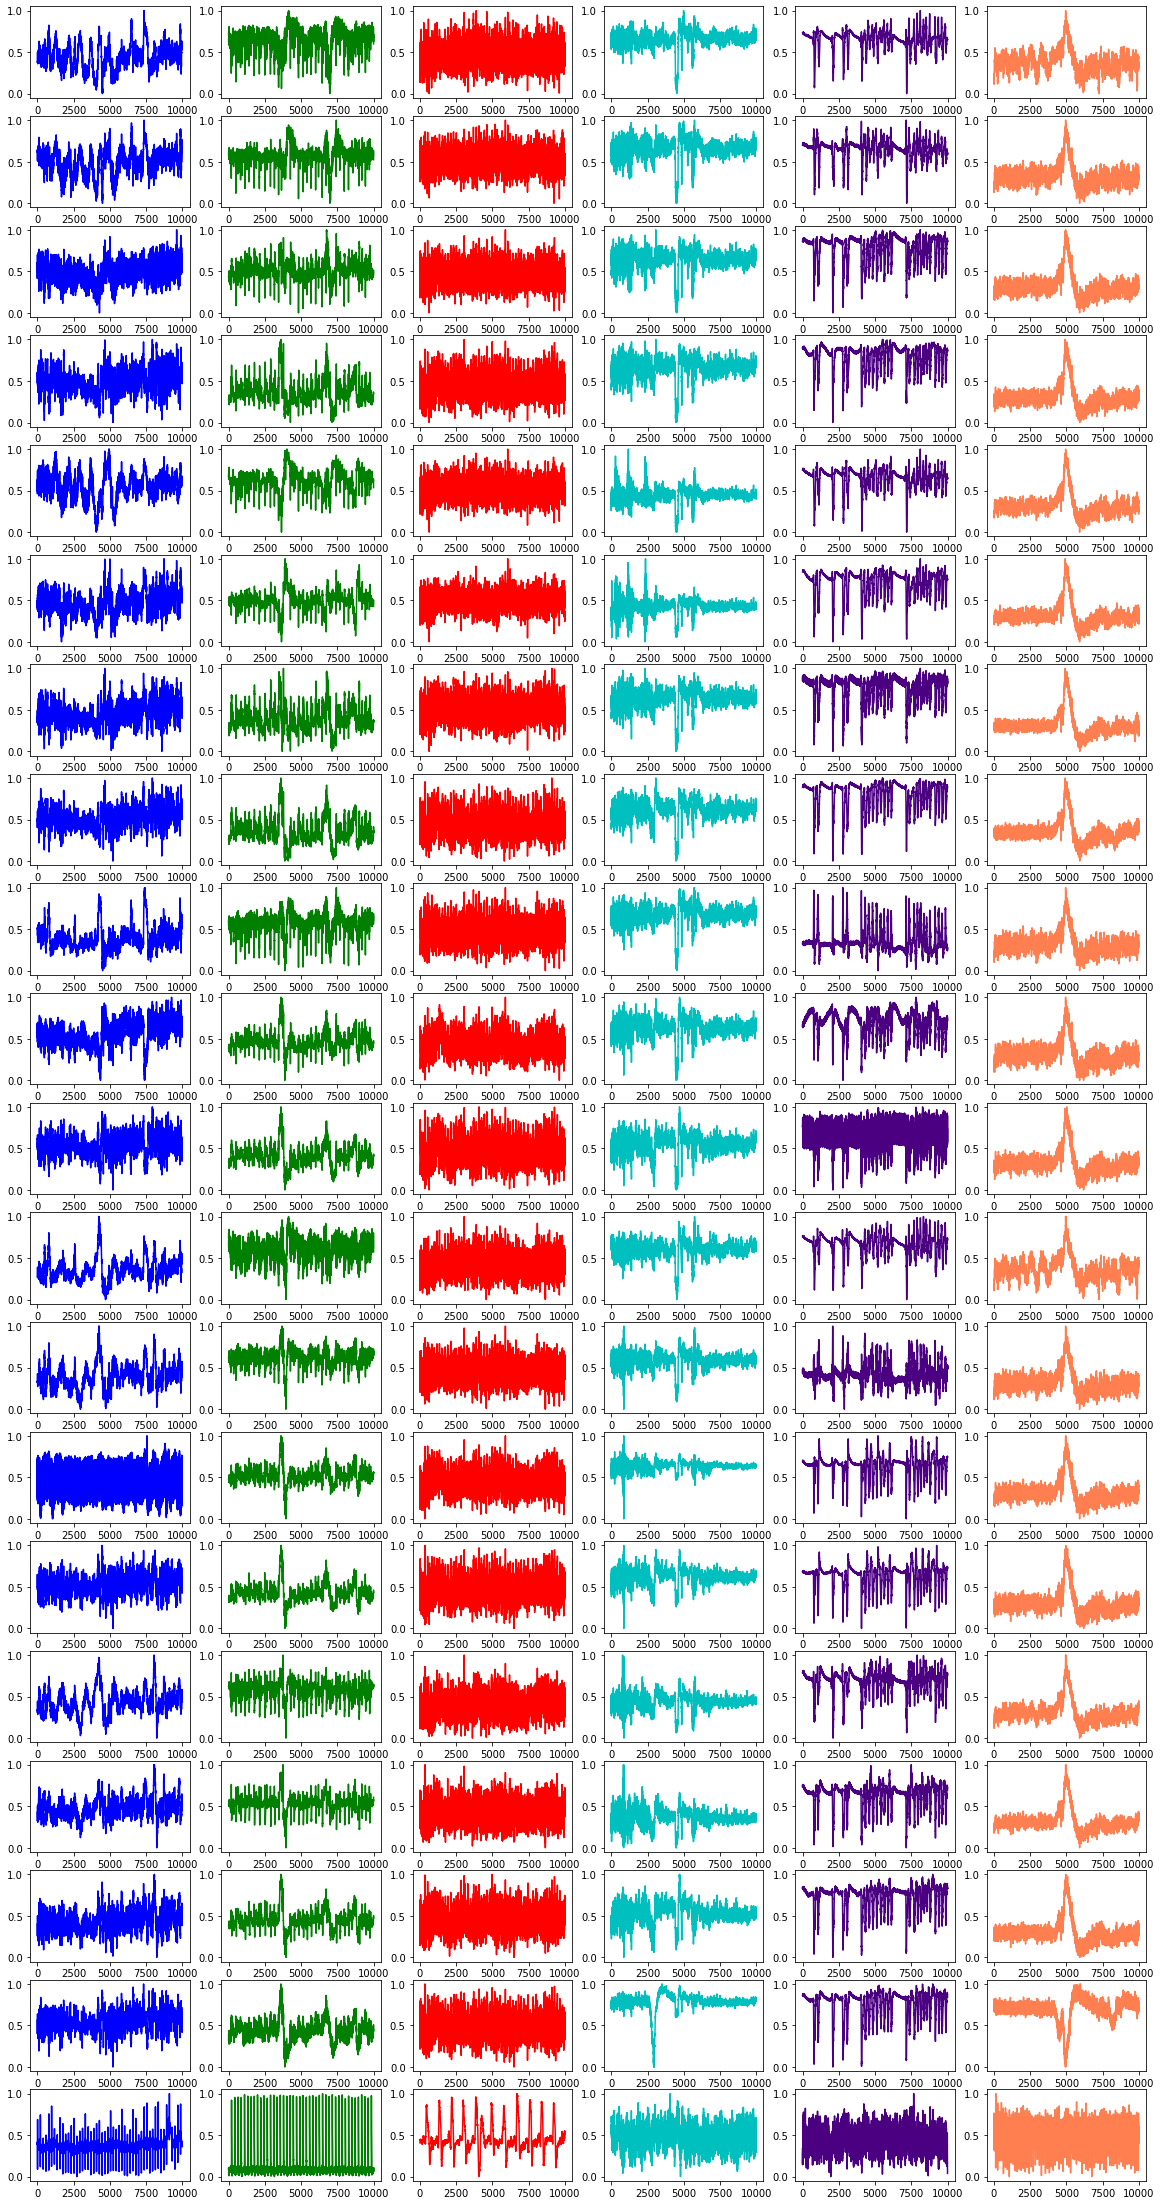

In [163]:
col_list = test_eeg.columns
eeg_list = [other_sub2, lpd_sub2, gpd_sub2, lrda_sub2, grda_sub2, seizure_sub2]
colors = ['b', 'g', 'r', 'c', 'indigo', 'coral']
fig, axs = plt.subplots(20, 6)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

##### Comparing Each Brain Activity Type with Seizure Activity  
  
The color key is the same as above.

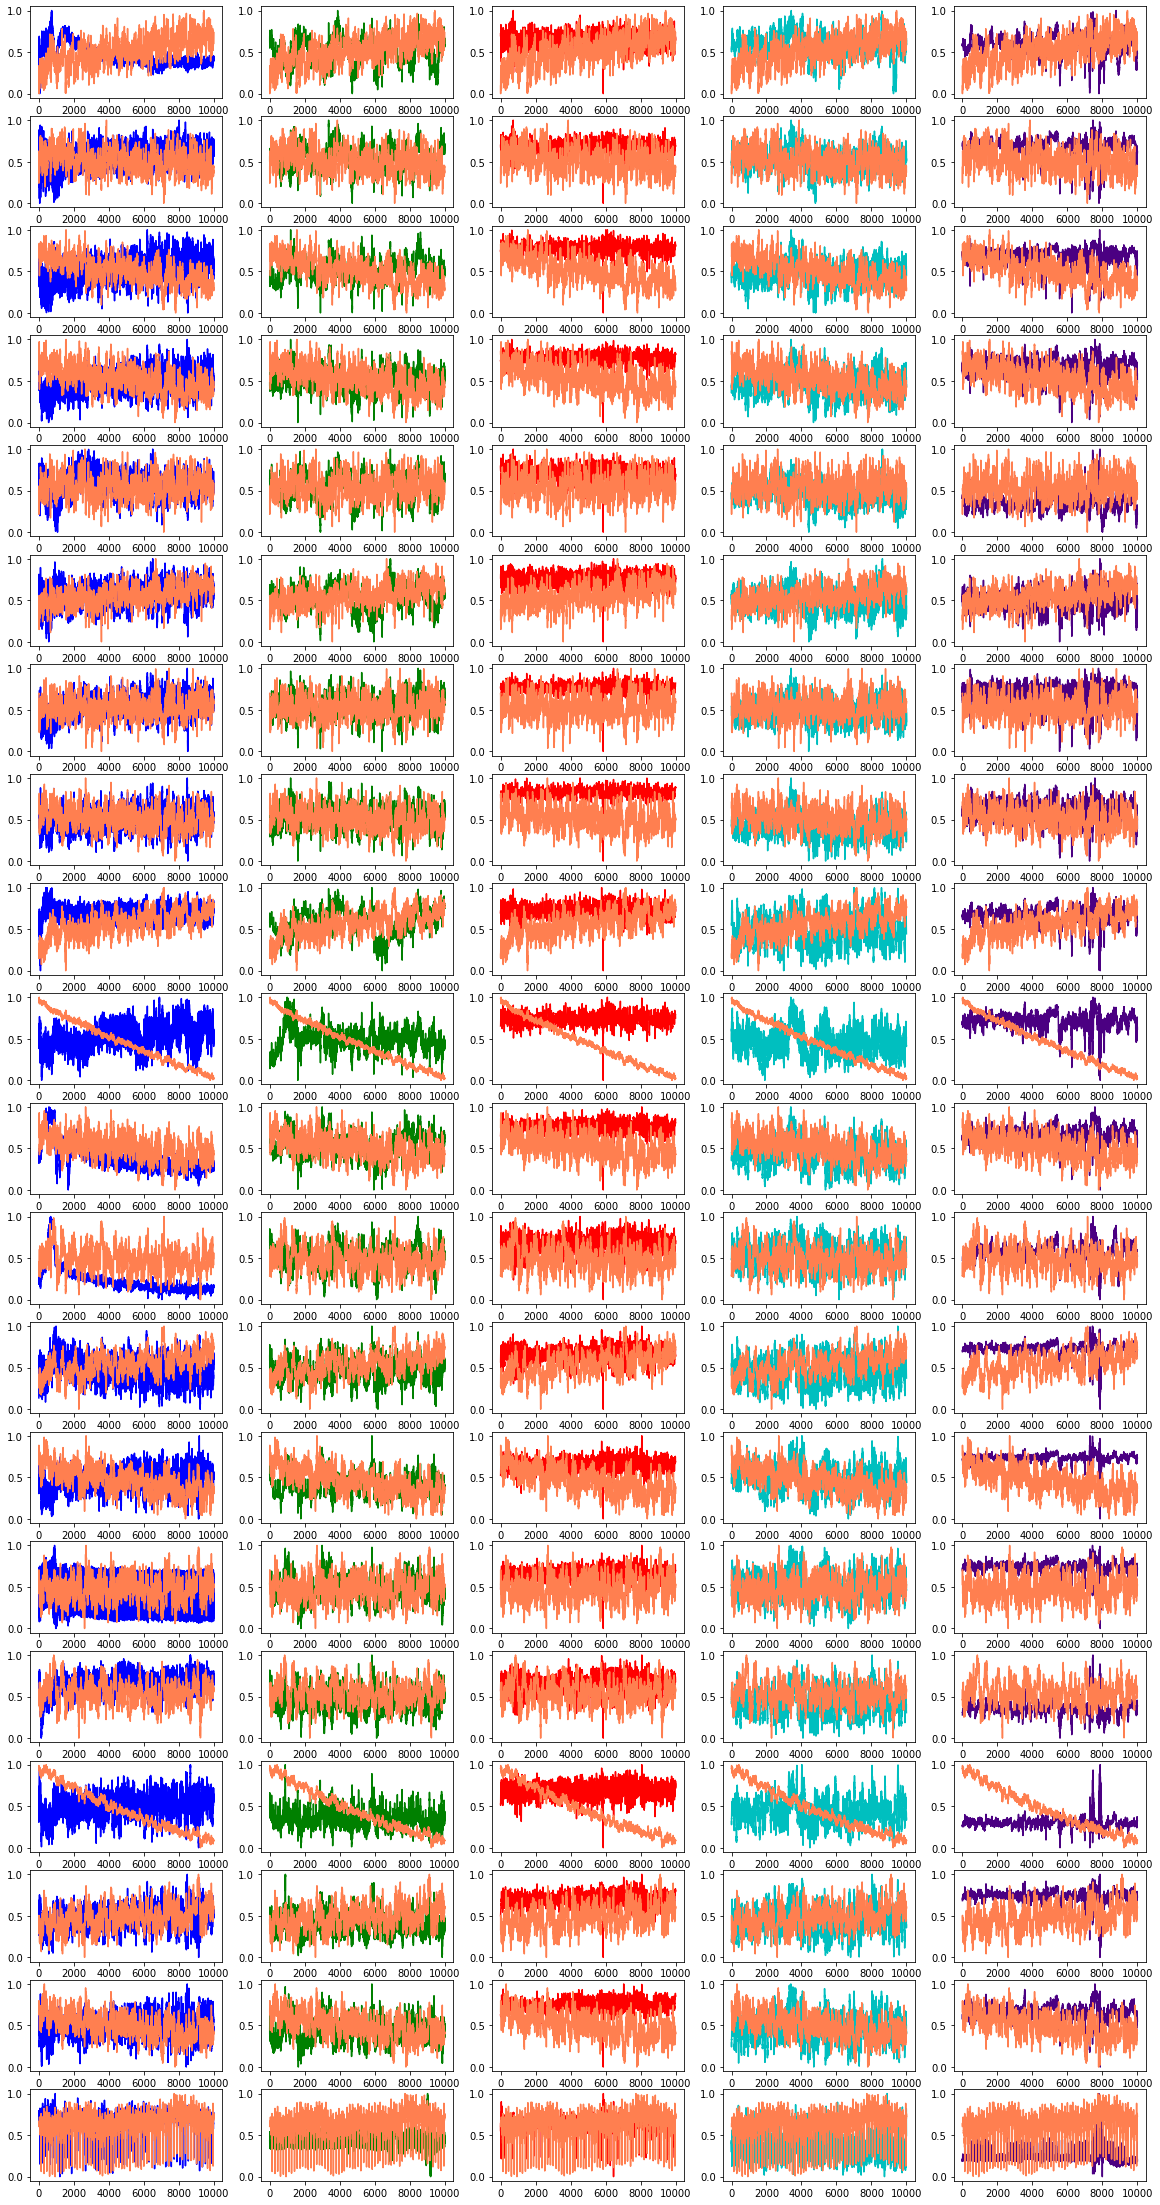

In [164]:
col_list = test_eeg.columns
eeg_list = [other_sub3, lpd_sub3, gpd_sub3, lrda_sub3, grda_sub3]
colors = ['b', 'g', 'r', 'c', 'indigo']
fig, axs = plt.subplots(20, 5)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        axs[i][j].plot(seizure_sub3[col_list[i]], color = 'coral')
        
plt.show()

##### Comparing Sub EEGs Within Each Target Class

##### Key:  
**Blue** - Sub EEG 1  
**Green** - Sub EEG 2  
**Red** - Sub EEG 3  
**Cyan** - Sub EEG 4  
**Purple** - Sub EEG 5

**Other**

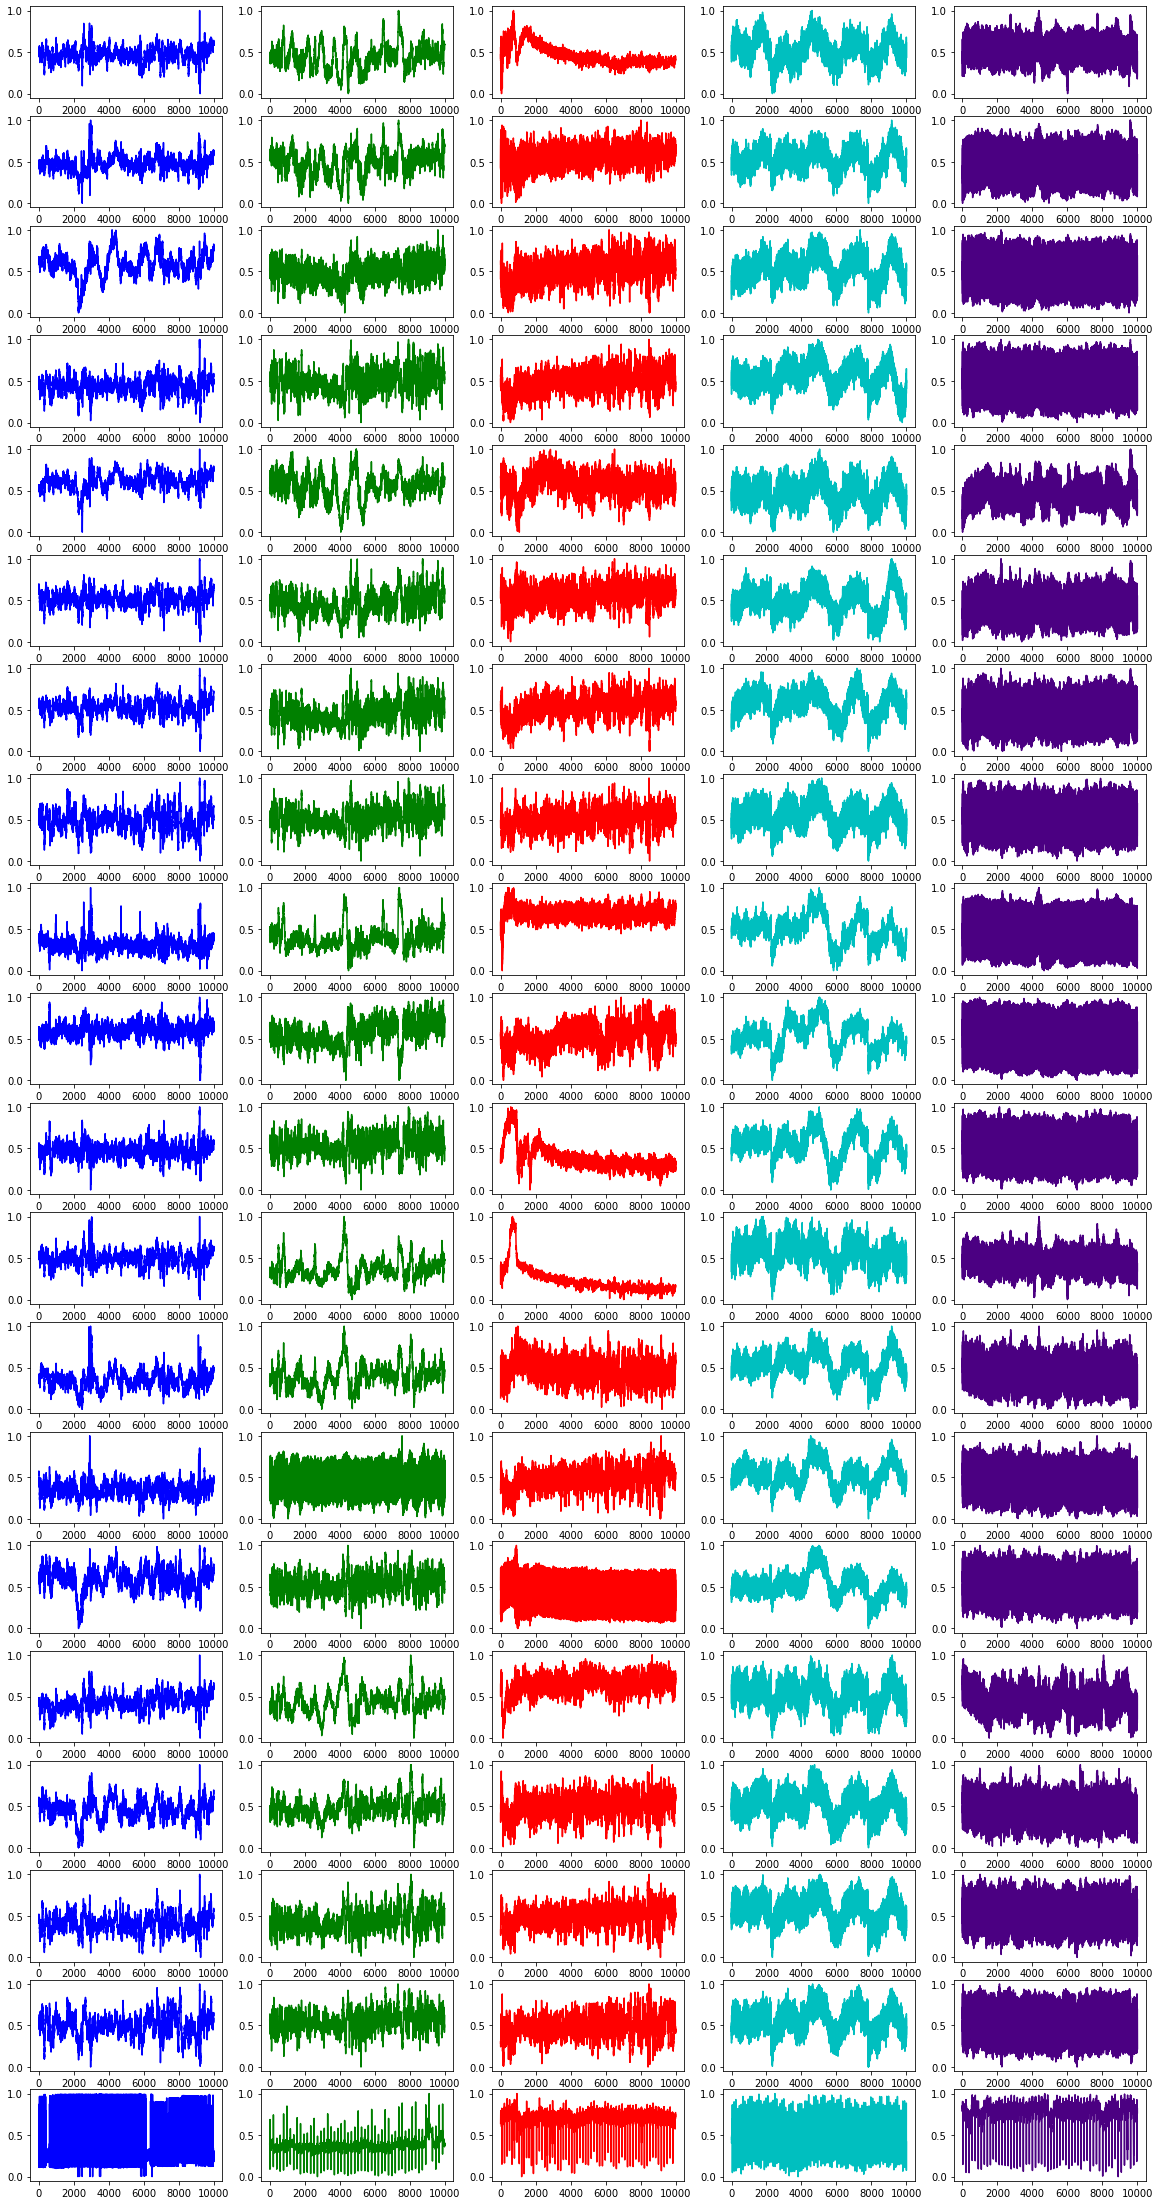

In [166]:
col_list = test_eeg.columns
eeg_list = [other_sub1, other_sub2, other_sub3, other_sub4, other_sub5]
colors = ['b', 'g', 'r', 'c', 'indigo']
fig, axs = plt.subplots(20, 5)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

When dealing with EEG data, the noisiness of the data is brought up and given as the reason why the raw data can't be used without some kind of transformation and feature extraction done. These plots show how variability sub EEGs can be despite having the same activity classification.

**LPD**

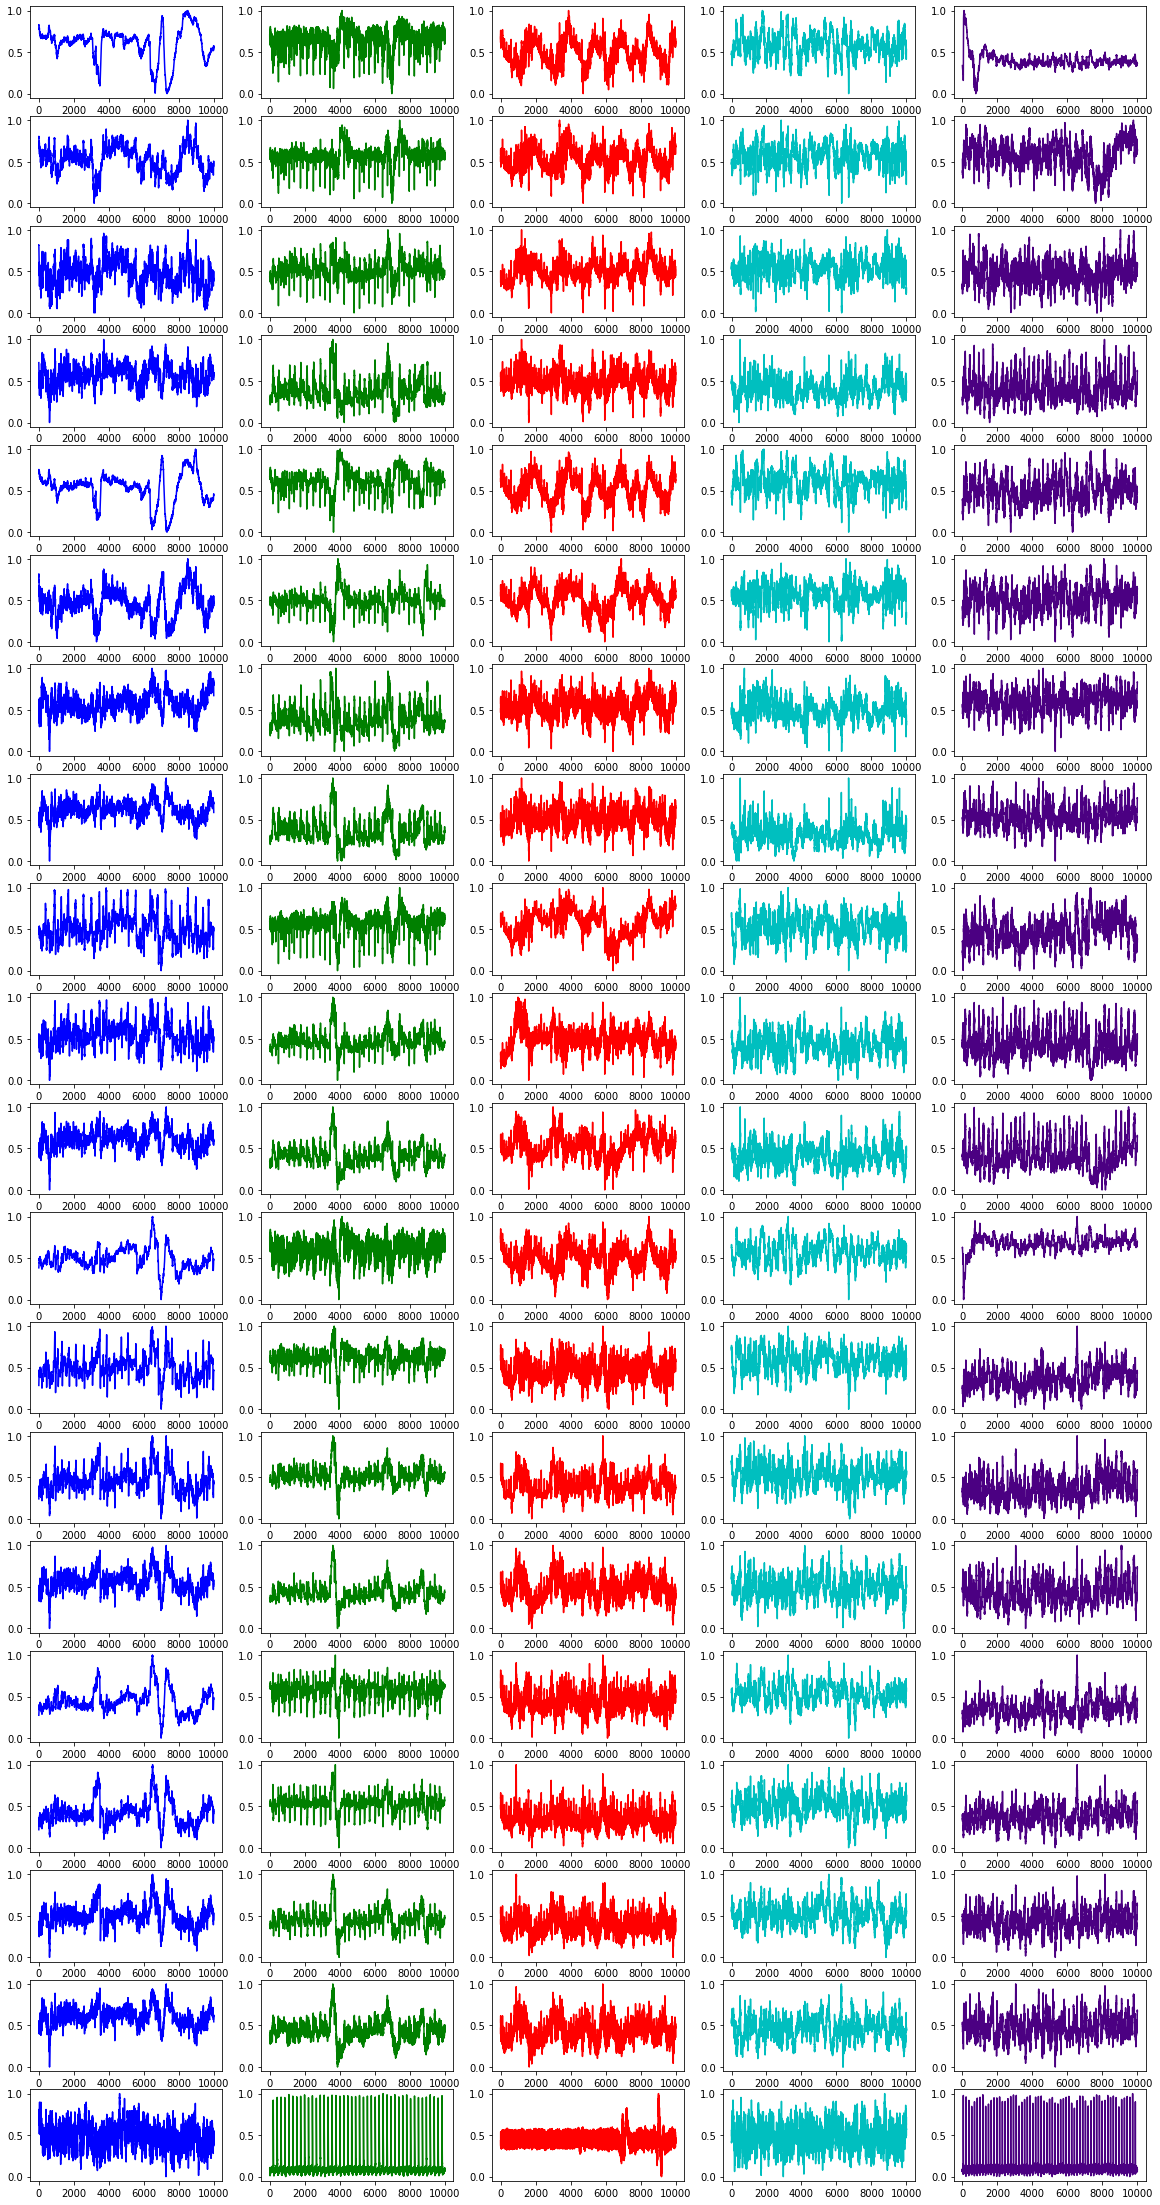

In [167]:
col_list = test_eeg.columns
eeg_list = [lpd_sub1, lpd_sub2, lpd_sub3, lpd_sub4, lpd_sub5]
colors = ['b', 'g', 'r', 'c', 'indigo']
fig, axs = plt.subplots(20, 5)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

**GPD**

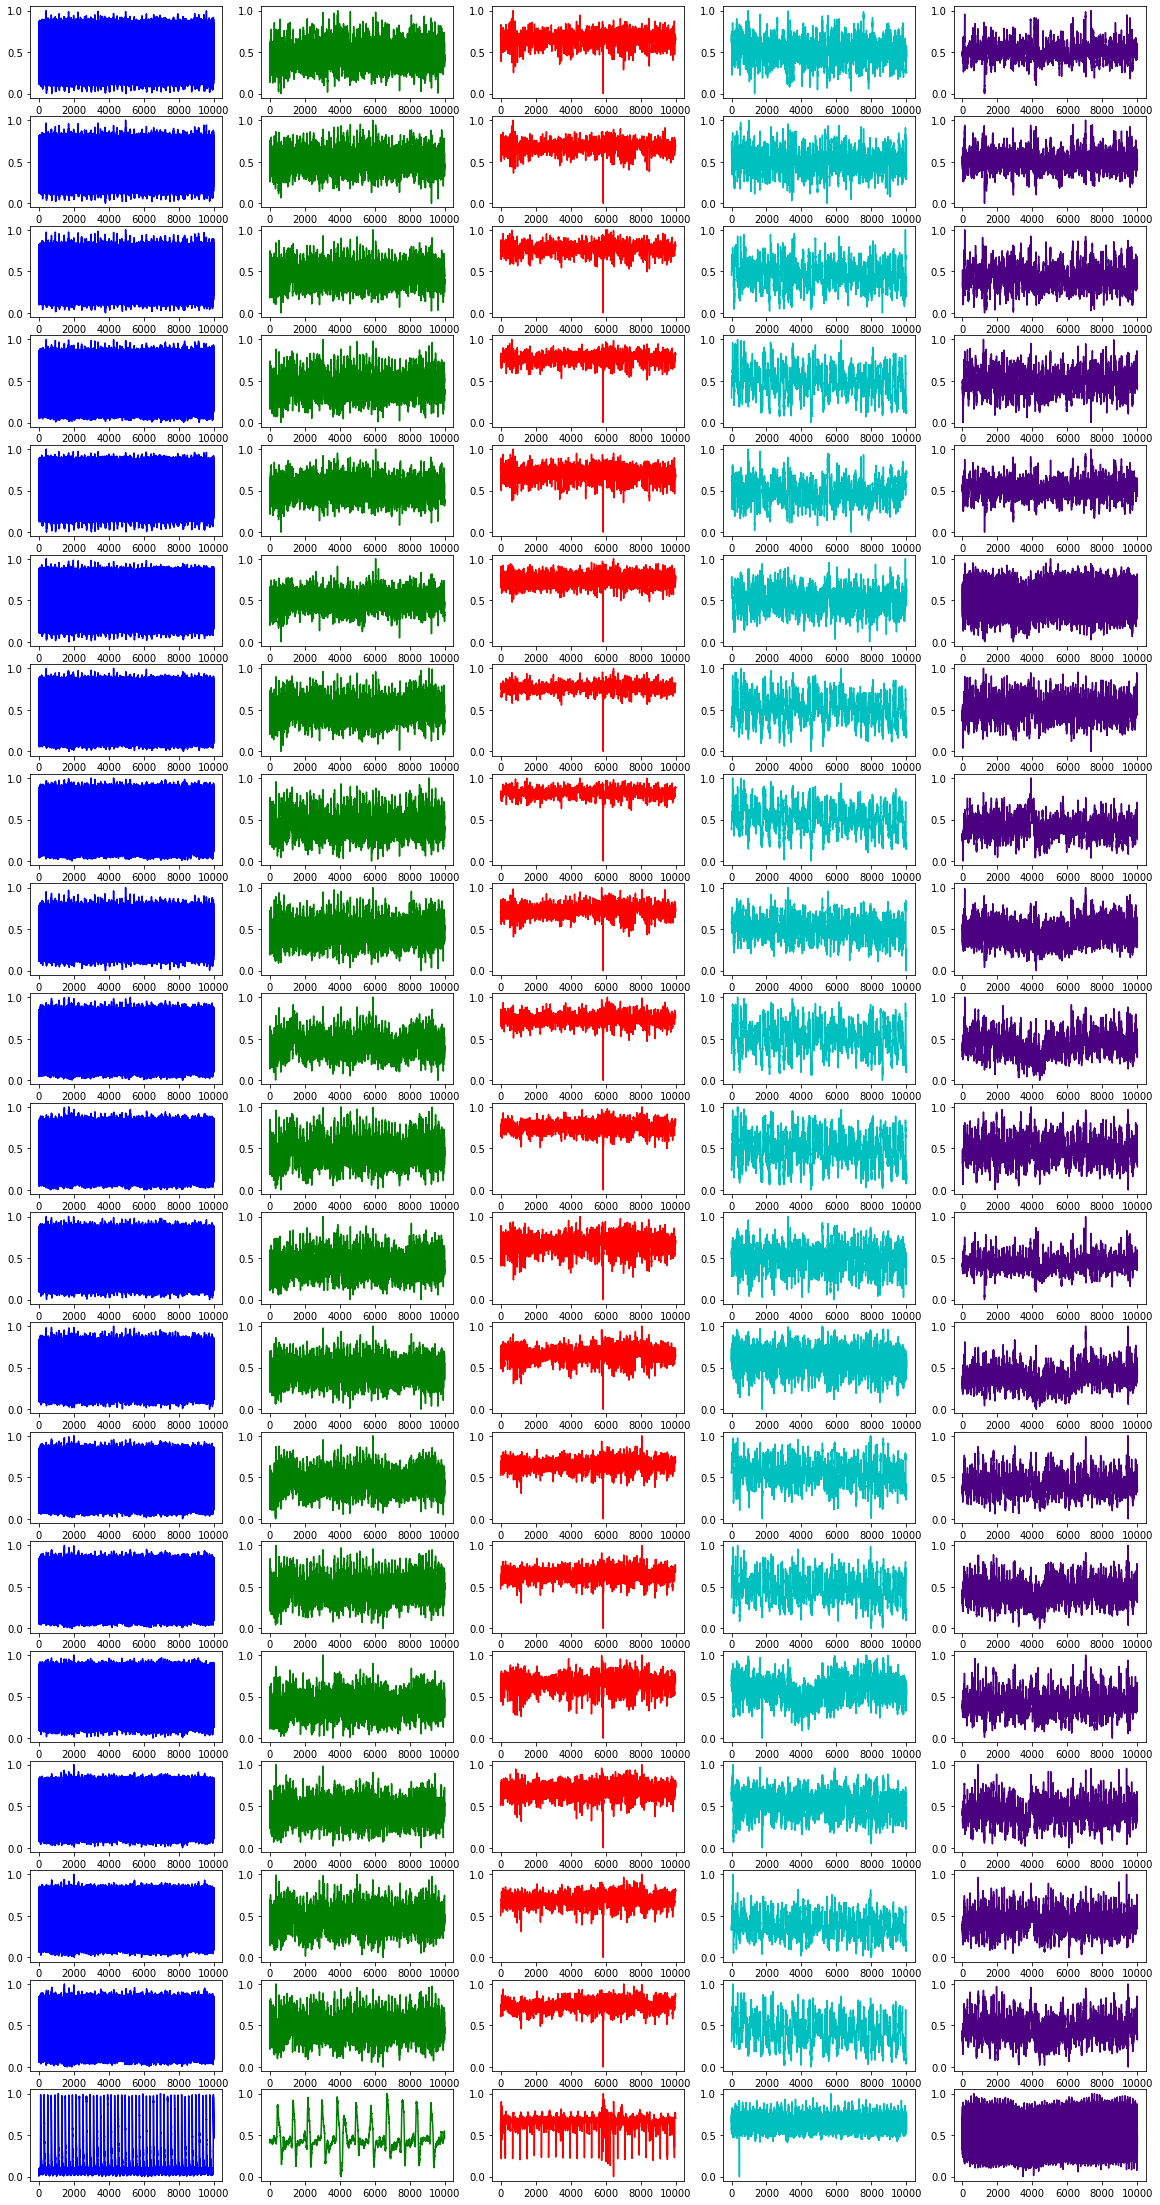

In [168]:
col_list = test_eeg.columns
eeg_list = [gpd_sub1, gpd_sub2, gpd_sub3, gpd_sub4, gpd_sub5]
colors = ['b', 'g', 'r', 'c', 'indigo']
fig, axs = plt.subplots(20, 5)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

The first sub EEG (blue) has extreme values in every column at every time point. This is likely due to some kind of error recording the results of the EEG.

**LRDA**

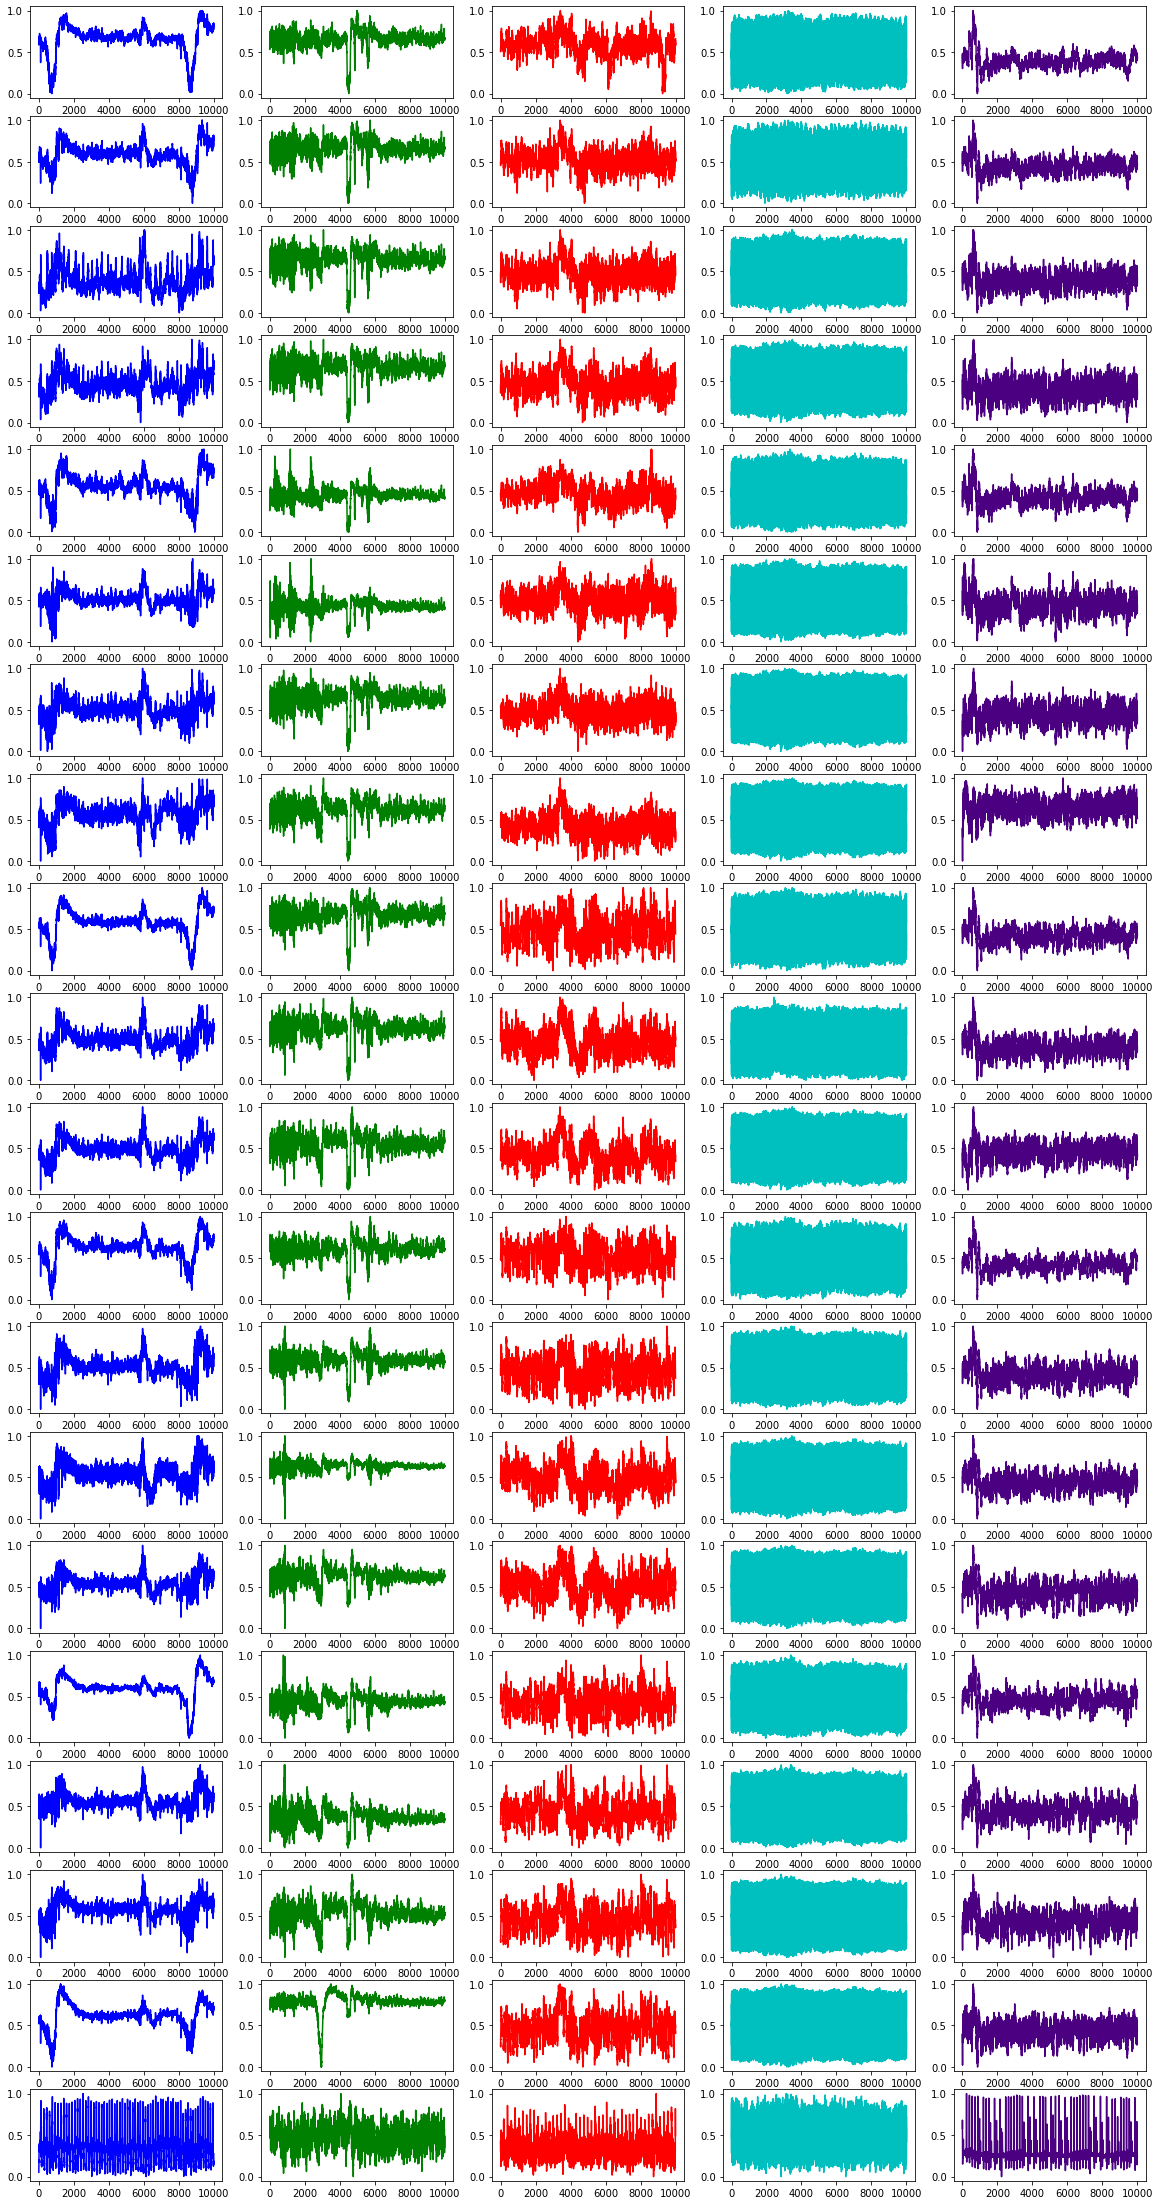

In [169]:
col_list = test_eeg.columns
eeg_list = [lrda_sub1, lrda_sub2, lrda_sub3, lrda_sub4, lrda_sub5]
colors = ['b', 'g', 'r', 'c', 'indigo']
fig, axs = plt.subplots(20, 5)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

Here it's the fourth sub EEG that seems to have errors.

**GRDA**

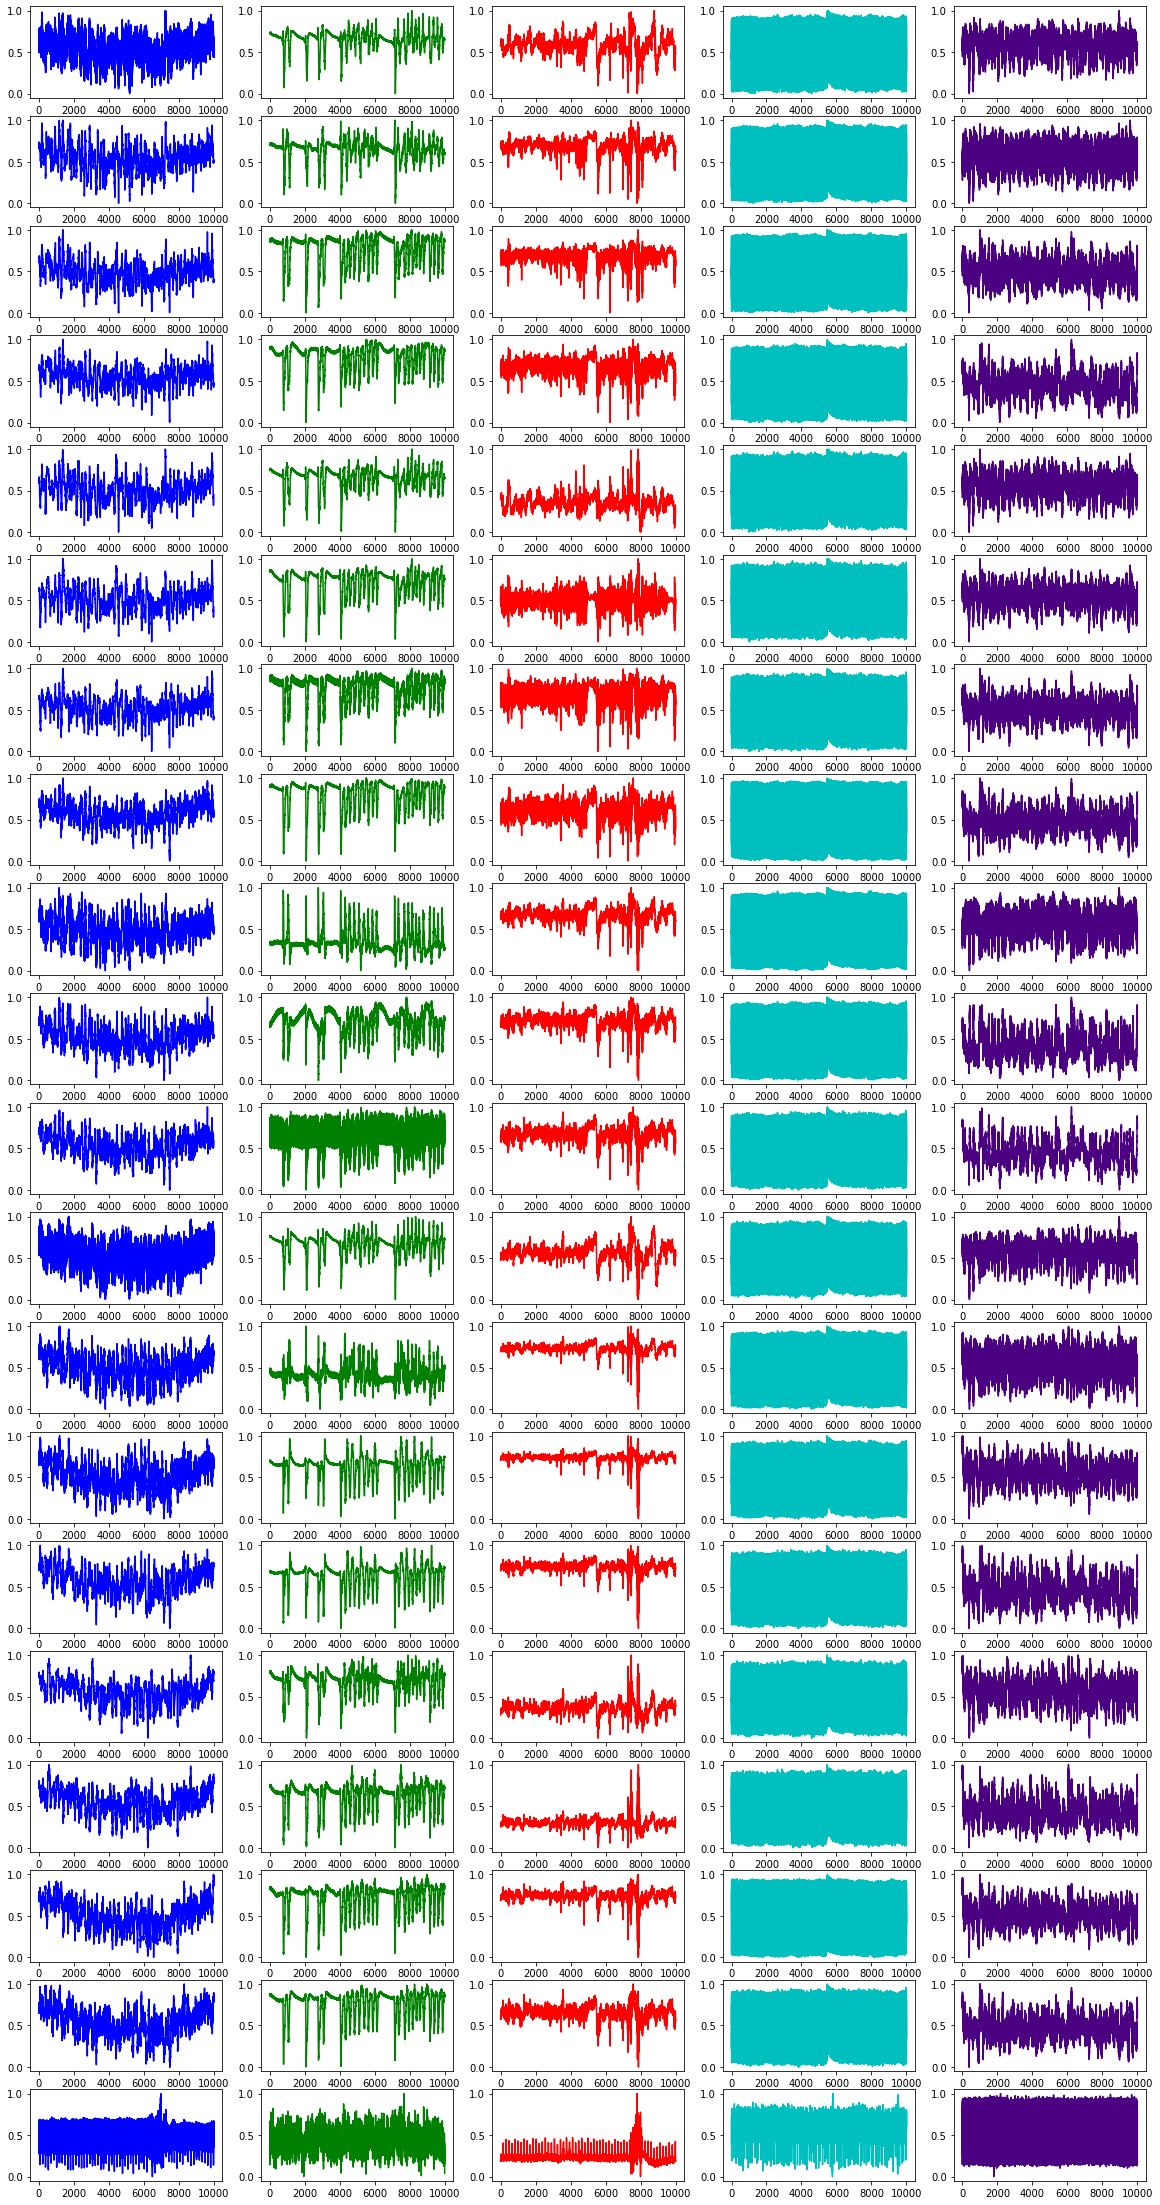

In [170]:
col_list = test_eeg.columns
eeg_list = [grda_sub1, grda_sub2, grda_sub3, grda_sub4, grda_sub5]
colors = ['b', 'g', 'r', 'c', 'indigo']
fig, axs = plt.subplots(20, 5)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

Again, it's the fourth sub EEG with this problem.

**Seizure**

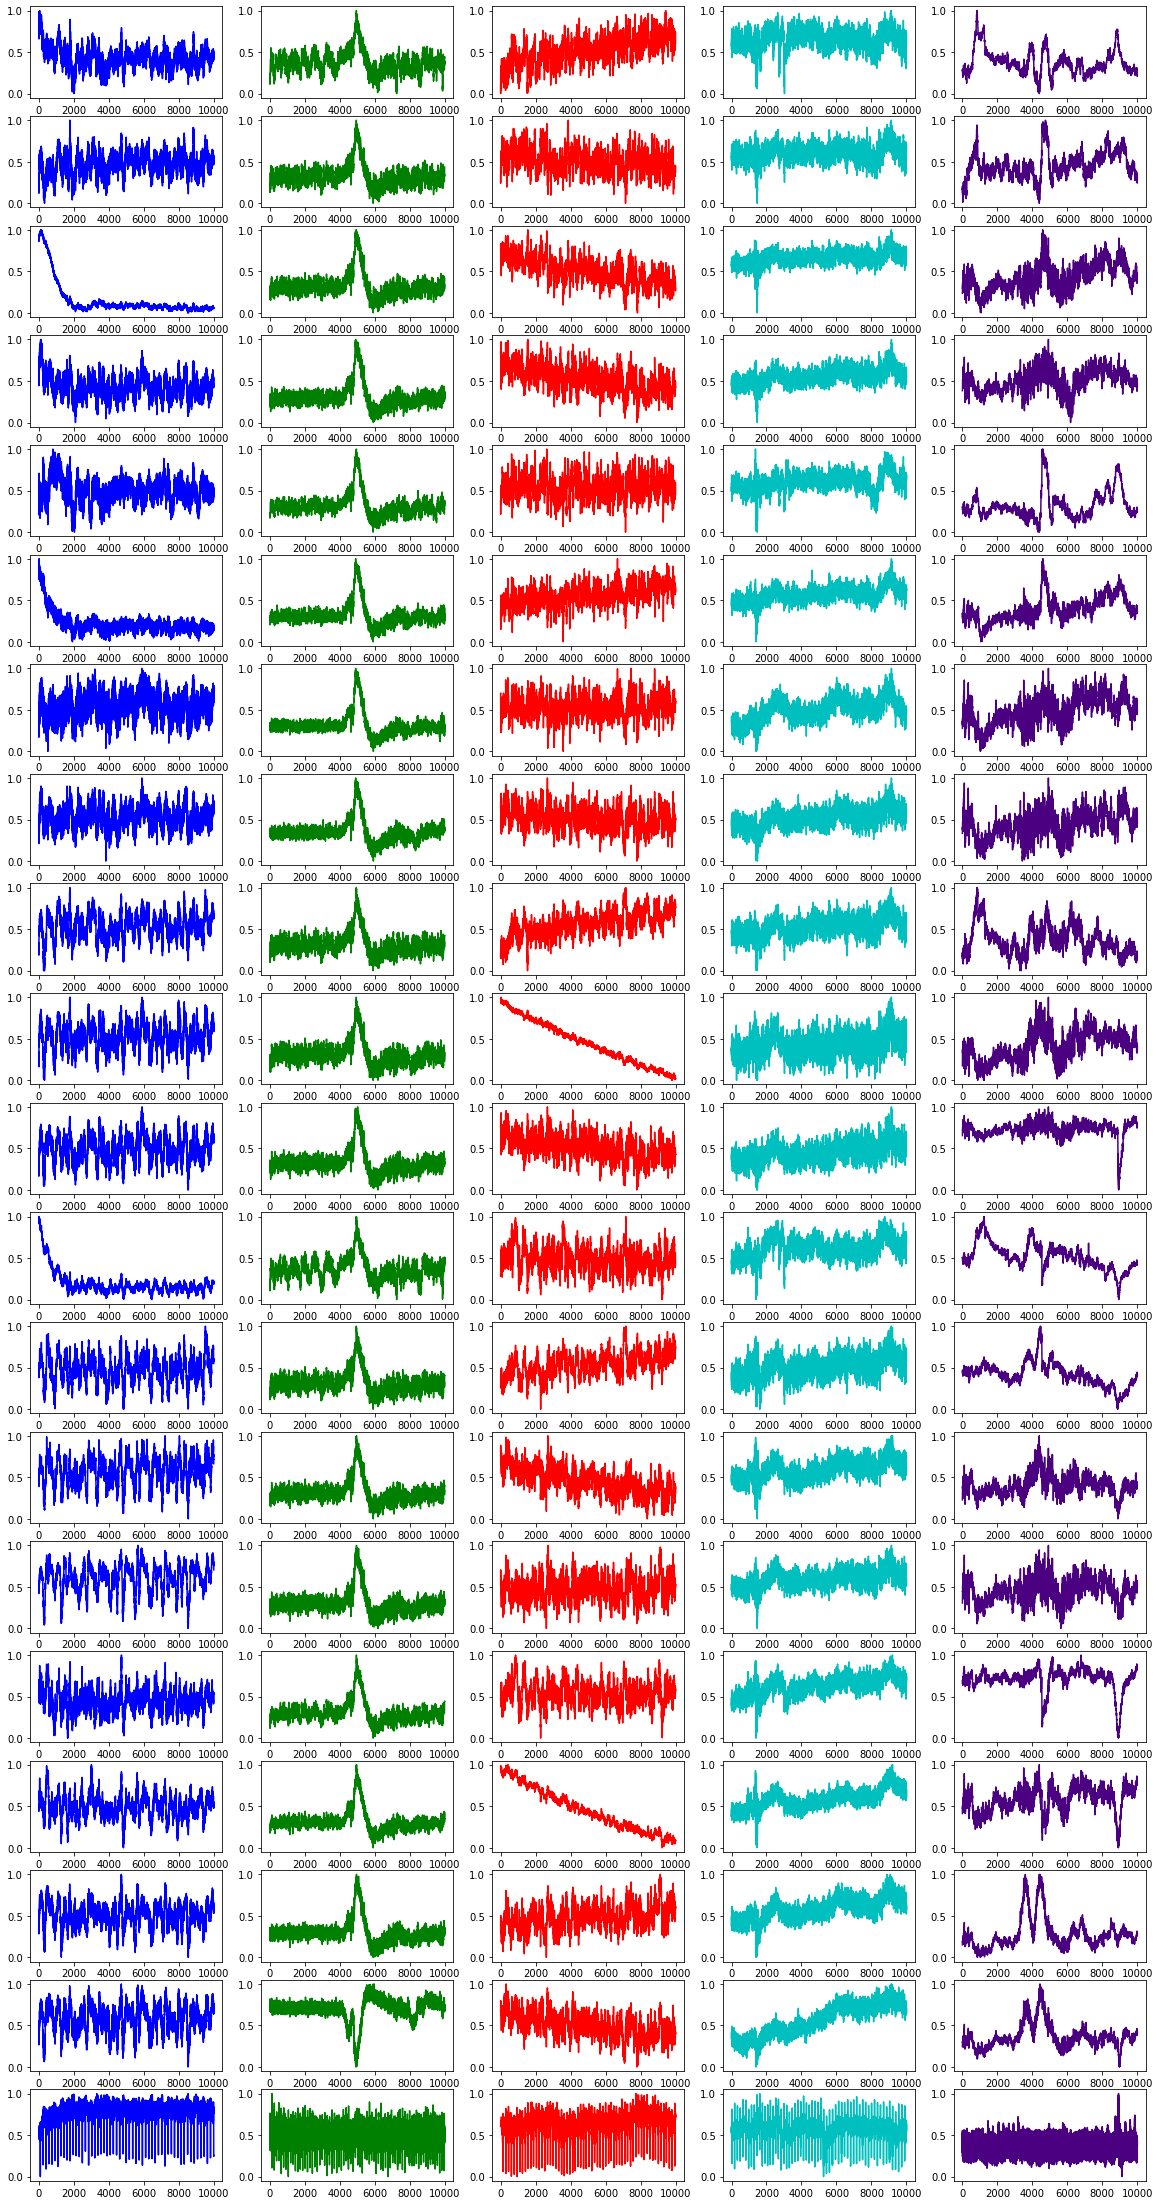

In [171]:
col_list = test_eeg.columns
eeg_list = [seizure_sub1, seizure_sub2, seizure_sub3, seizure_sub4, seizure_sub5]
colors = ['b', 'g', 'r', 'c', 'indigo']
fig, axs = plt.subplots(20, 5)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

#### One More Set of Plots  
  
Before working on the feature extraction part of this problem, I want to generate sub EEGs for each class which may be more representative of the overall data for that class. To do this, I'll take in 1000 sub EEGs for each class and average them to get an average sub EEG for that class. Then I'll plot these to see how things change from what's been seen in the above plots.

This function checks for null values in the sub EEG.

In [172]:
def has_null(sub_eeg):
    col_sum = pd.isnull(sub_eeg).sum()
    null_sum = sum(col_sum)
    if null_sum > 0:
        return True
    else:
        False

This function takes a specified row and gets the sub EEG for that row.

In [175]:
def get_sub_eeg(data, row):
    eeg_id = str(data['eeg_id'][row])
    eeg_parquet = eeg_id + '.parquet'
    eeg = pd.read_parquet('train_eegs/' + eeg_parquet, engine = 'pyarrow')
    starting_row = int(data['eeg_label_offset_seconds'][row] * 200)
    ending_row = int(starting_row + 10000)
    sub_eeg = eeg.iloc[starting_row: ending_row]
    sub_eeg = sub_eeg.reset_index()
    sub_eeg = sub_eeg.drop(columns = 'index')
    return sub_eeg

This function takes in a specified number of rows, gets the sub EEG for those rows, adds them together, and then calculates the average.

In [173]:
def get_avg_eeg(data, num_rows):
    z = np.zeros((10000, 20))
    z = pd.DataFrame(z, columns = test_eeg.columns)
    for i in range(num_rows):
        sub_eeg = get_sub_eeg(data, i)
        if has_null(sub_eeg):
            sub_eeg = replace_nulls(sub_eeg)
        sub_eeg = scale(sub_eeg)
        z += sub_eeg
    avg_eeg = z / num_rows
    return avg_eeg

In [178]:
other_avg = get_avg_eeg(other_df, 1000)
lpd_avg = get_avg_eeg(lpd_df, 1000)
gpd_avg = get_avg_eeg(gpd_df, 1000)
lrda_avg = get_avg_eeg(lrda_df, 1000)
grda_avg = get_avg_eeg(grda_df, 1000)
seizure_avg = get_avg_eeg(seizure_df, 1000)

##### Key:  
  
**Blue** - Other  
**Green** - LPD  
**Red** - GPD  
**Cyan** - LRDA  
**Purple** - GRDA  
**Coral** - Seizure

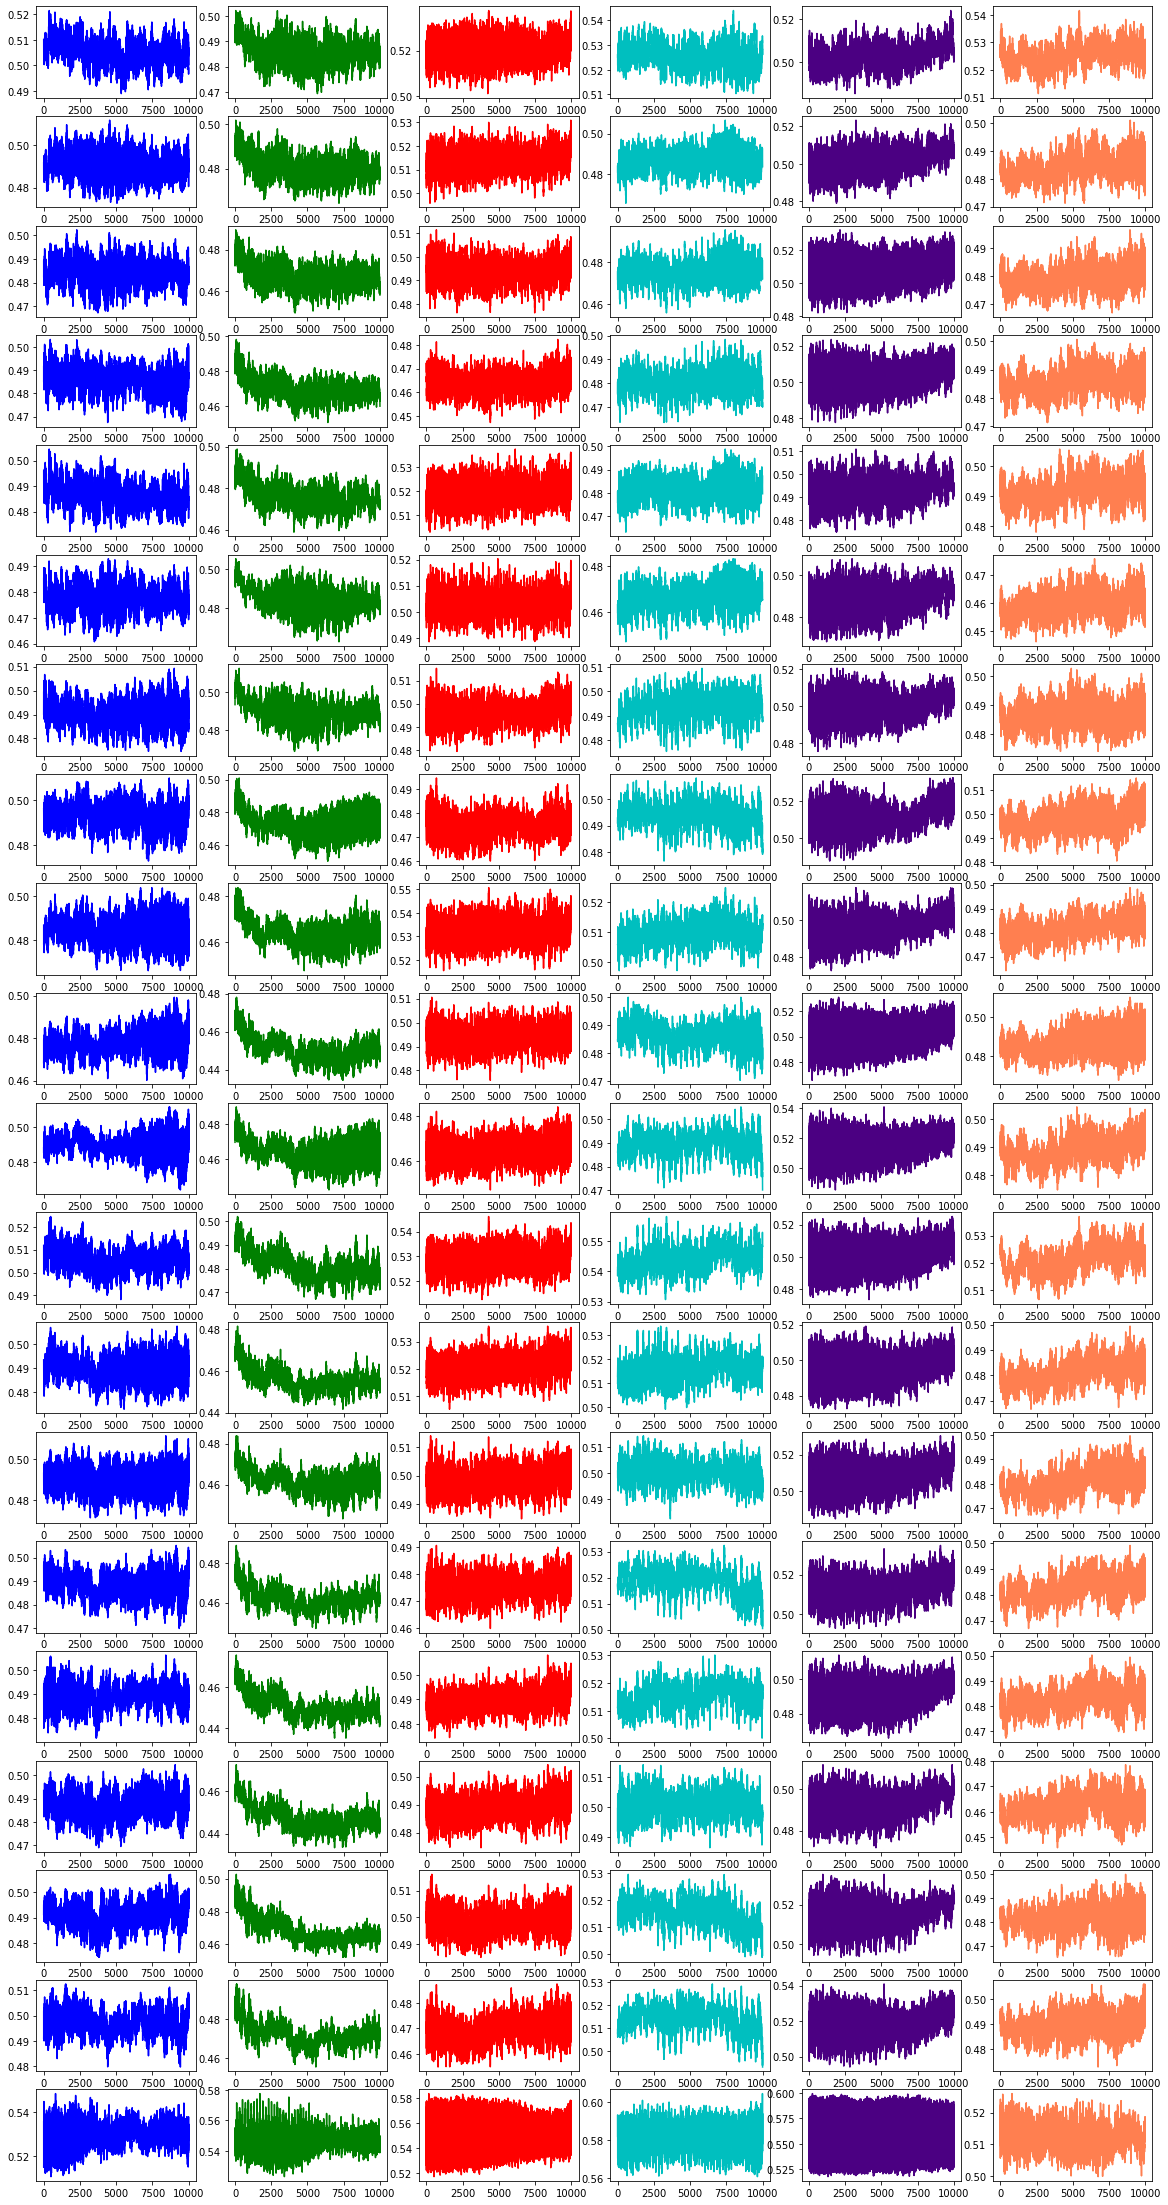

In [179]:
col_list = test_eeg.columns
eeg_list = [other_avg, lpd_avg, gpd_avg, lrda_avg, grda_avg, seizure_avg]
colors = ['b', 'g', 'r', 'c', 'indigo', 'coral']
fig, axs = plt.subplots(20, 6)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

In order to better visualize the results above, I need to set the y axis to being from 0 to 1 instead of the limited range shown. There do appear to be trends, however. For example, the average seizure data shows a signal that gets larger over time. The average GRDA data shows a signal that starts large and gets smaller over time. The LPD data shows a thinner signal throughout that starts at higher values and decreases. In other words, the difference between high and low points doesn't appear to change as much as for seizure and GRDA activity. The interesting thing for the LPD signal is that as time moves forward, the averages signal decreases.